# Урок 1. Введение в спортивный анализ данных, Exploration Data Analysis.

In [1]:
!pip install missingno

In [3]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\Rush\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

## Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [4]:
train.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [5]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [6]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [7]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 1


In [8]:
numerical_features_test = test.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_test.shape[1]}")

numerical_features_test.columns

count of numeric_features 200


Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [9]:
discrete_feature_test = [
    feature for feature in numerical_features_test
    if len(test[feature].unique())<25 
]

print(f"Discrete Variables Count: {len(discrete_feature_test)}")

Discrete Variables Count: 0


- Данные для трейна представлены числовыми признаками, только одна колонка представлена признаками дискретными
- На тесте все признаки числовые.

In [10]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ["ID_code"]]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


In [11]:
def group(iterable, count):
    """ Группировка элементов последовательности по count элементов """ 
    return zip(*[iter(iterable)] * count)

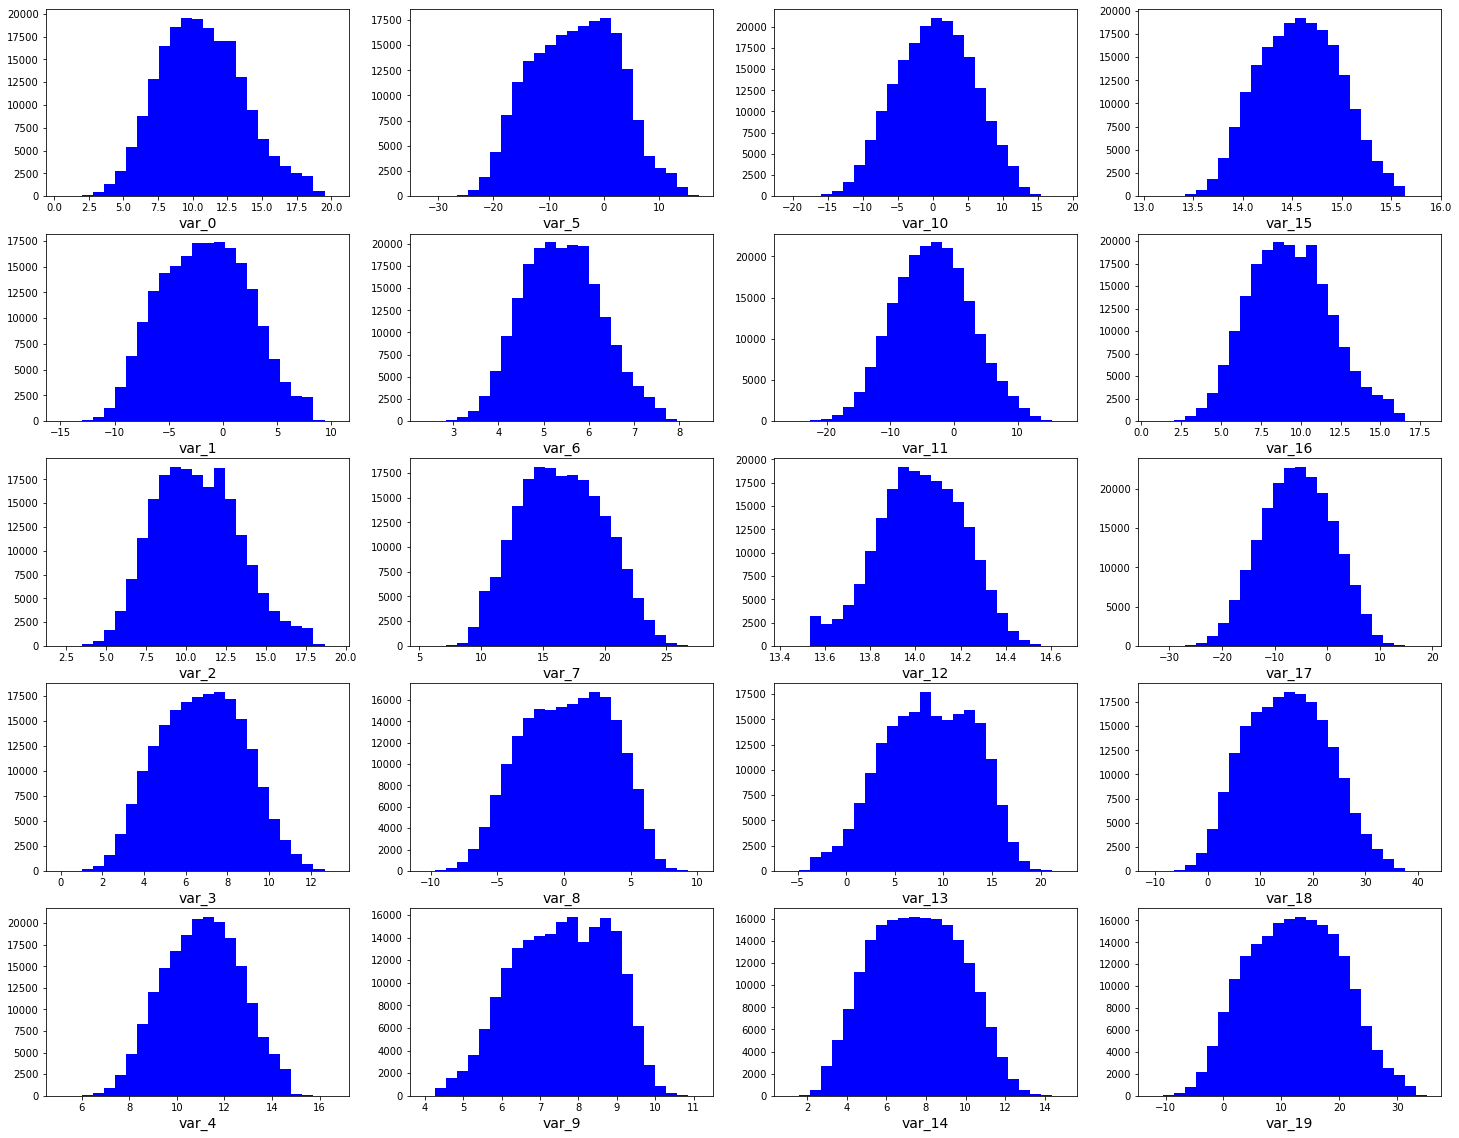

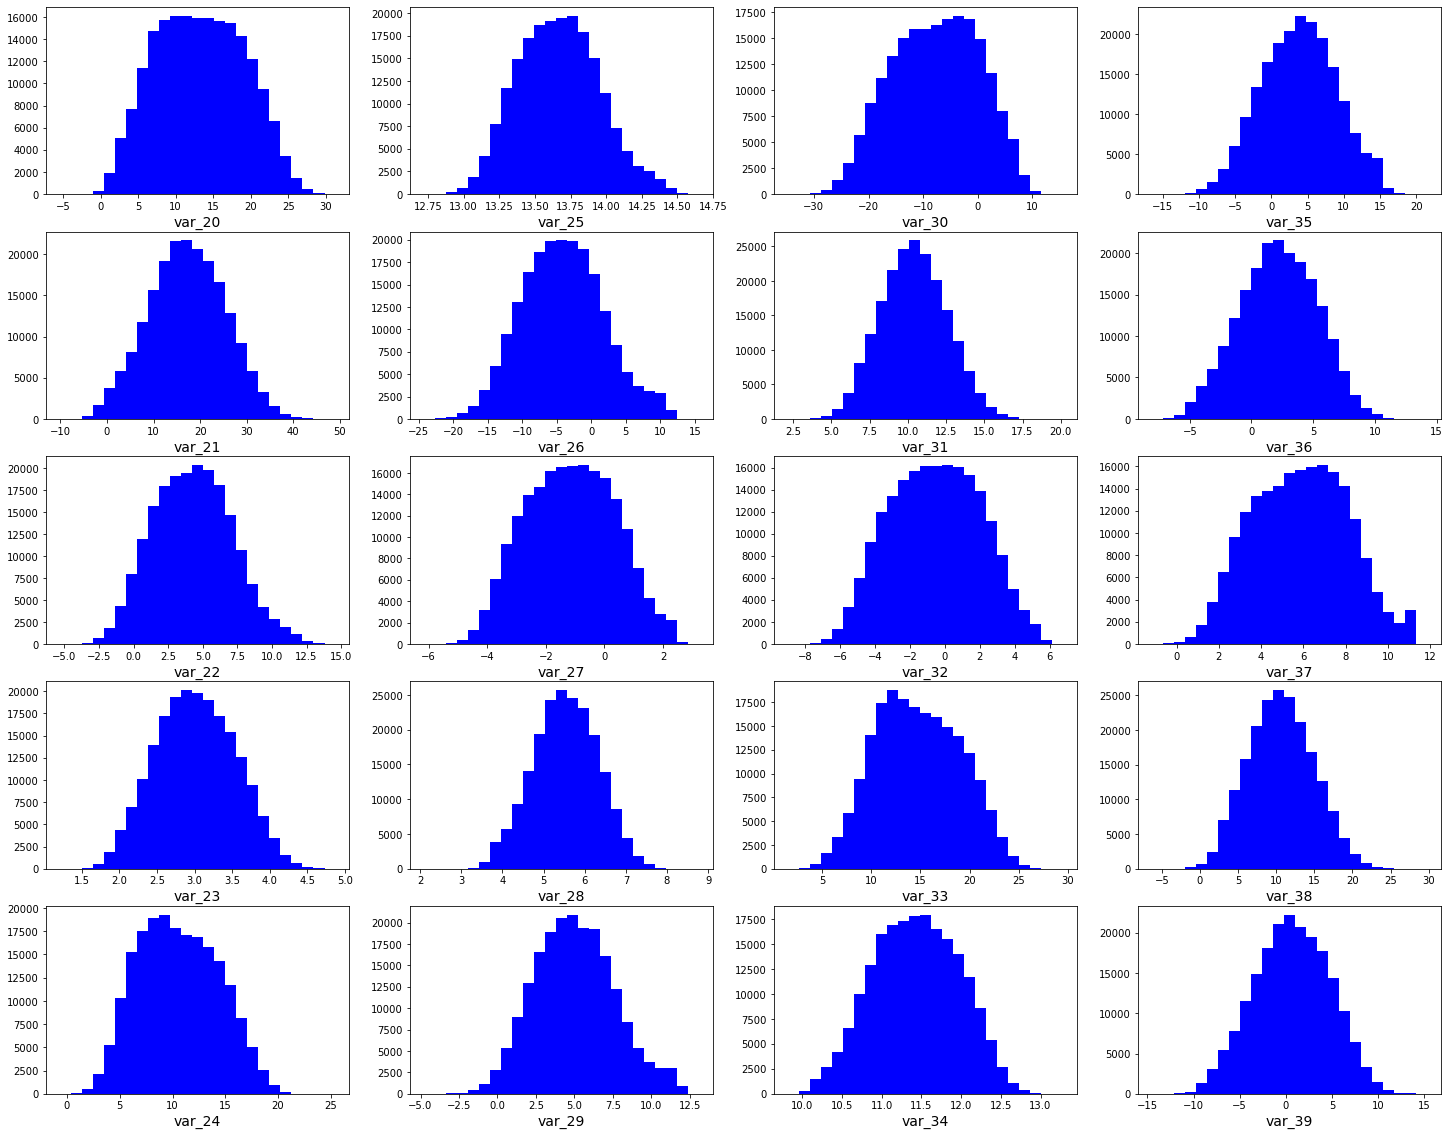

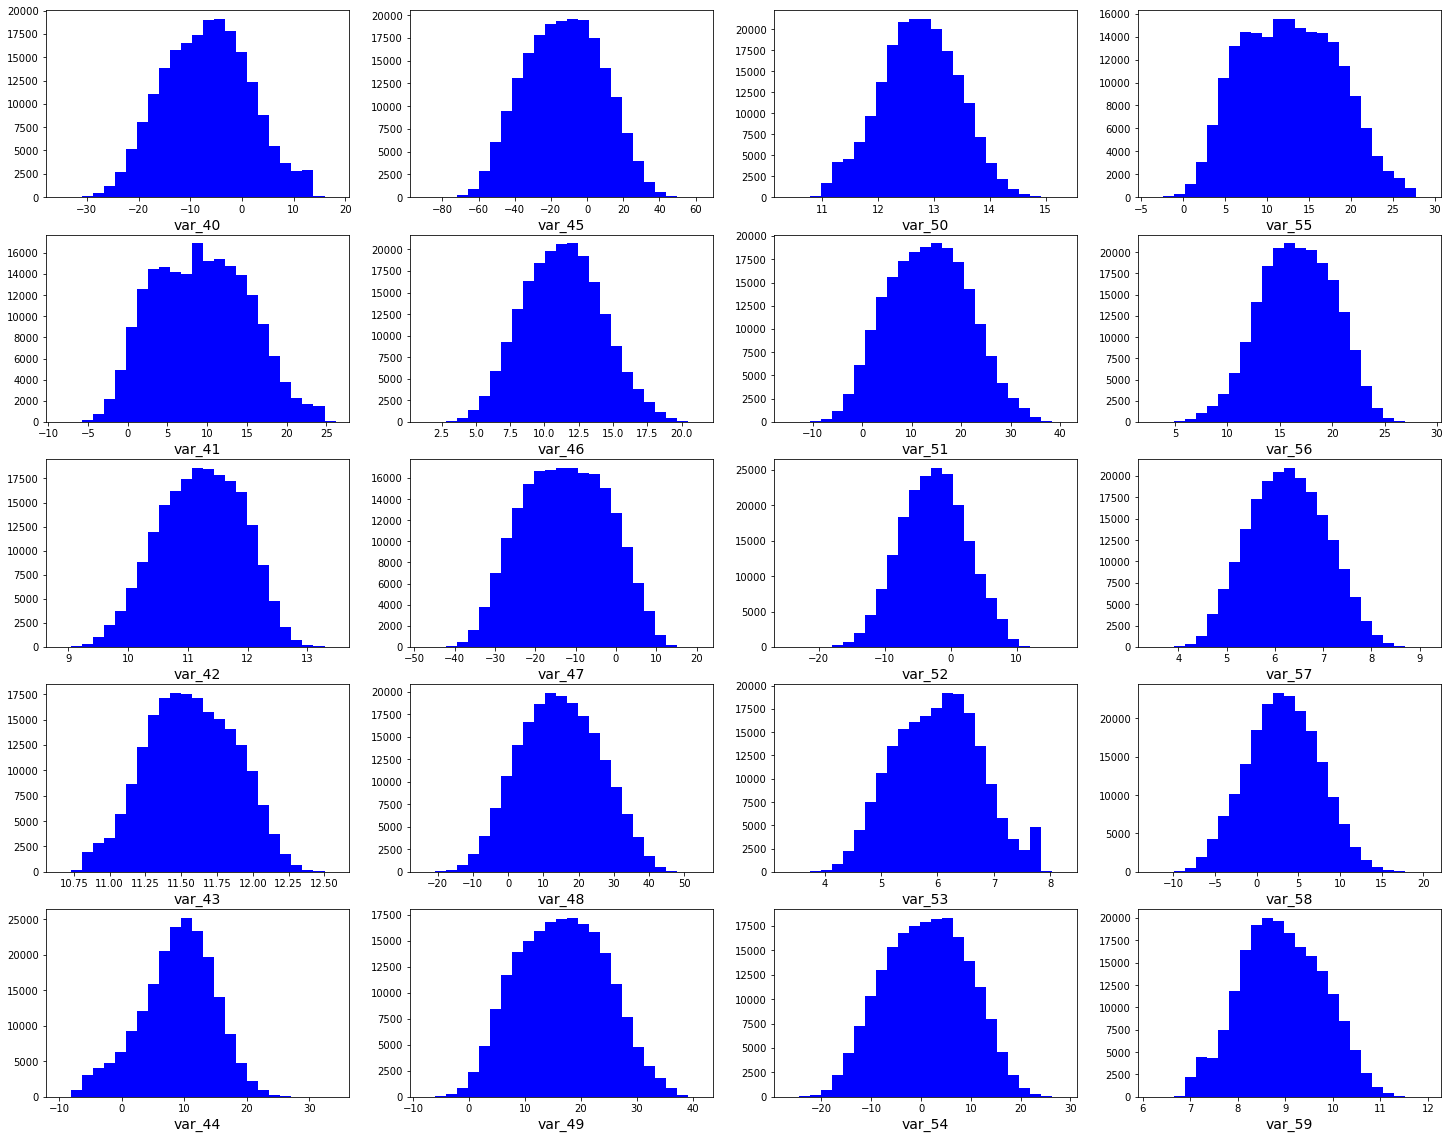

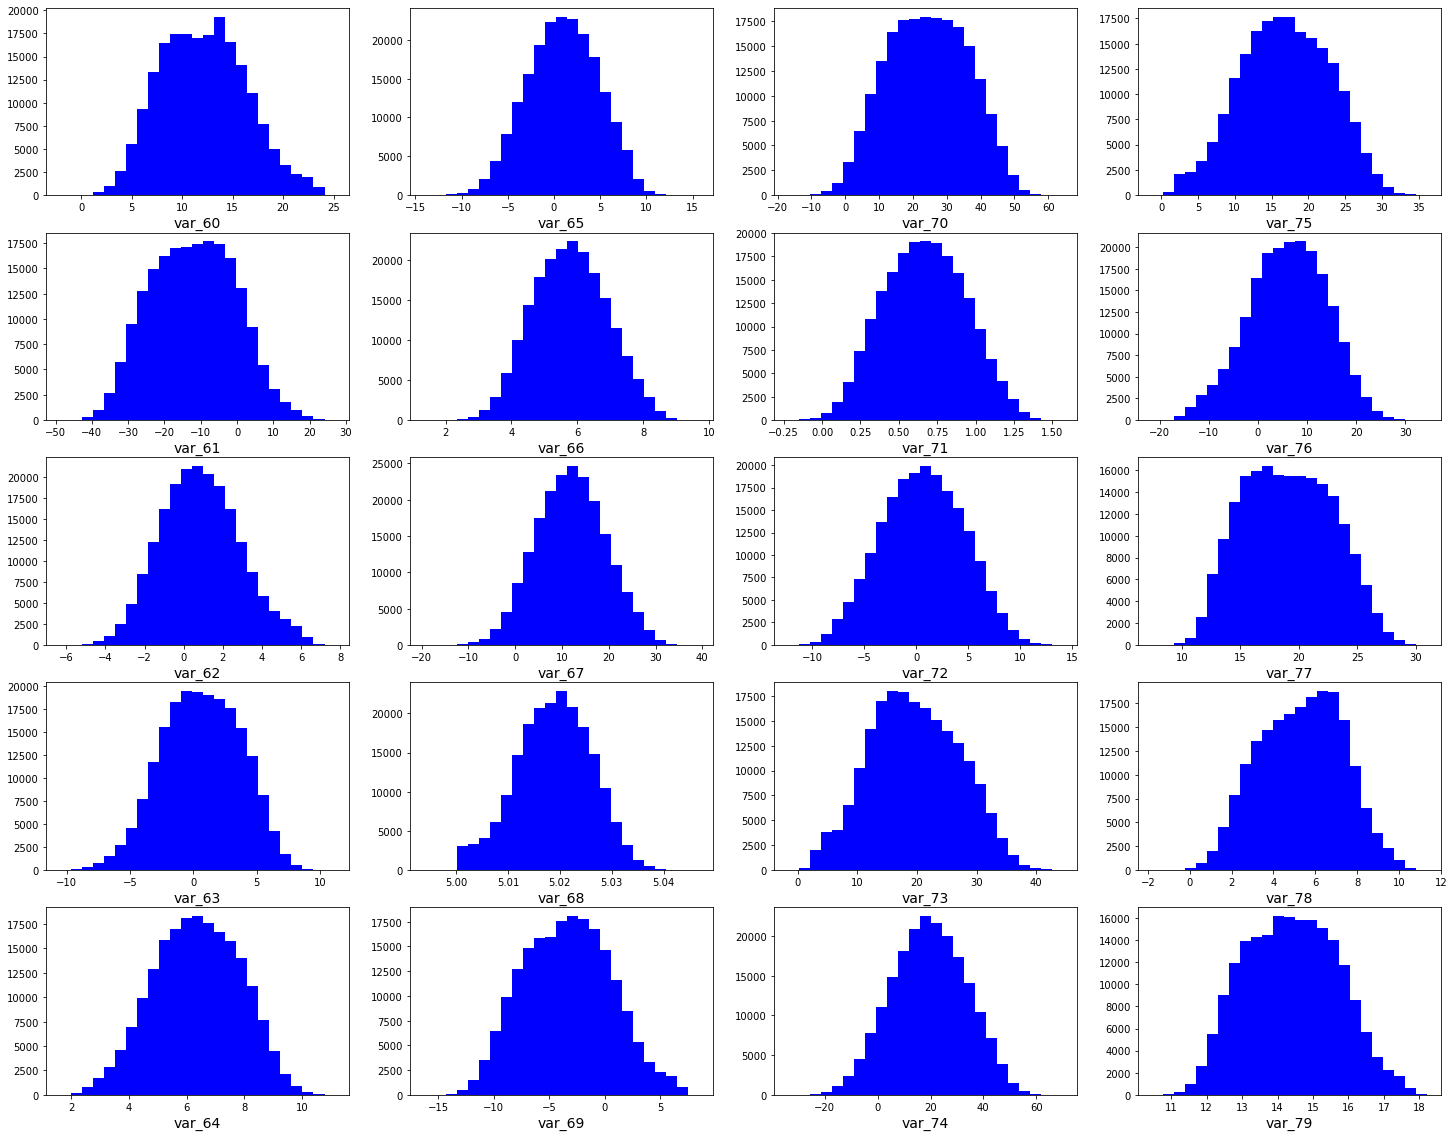

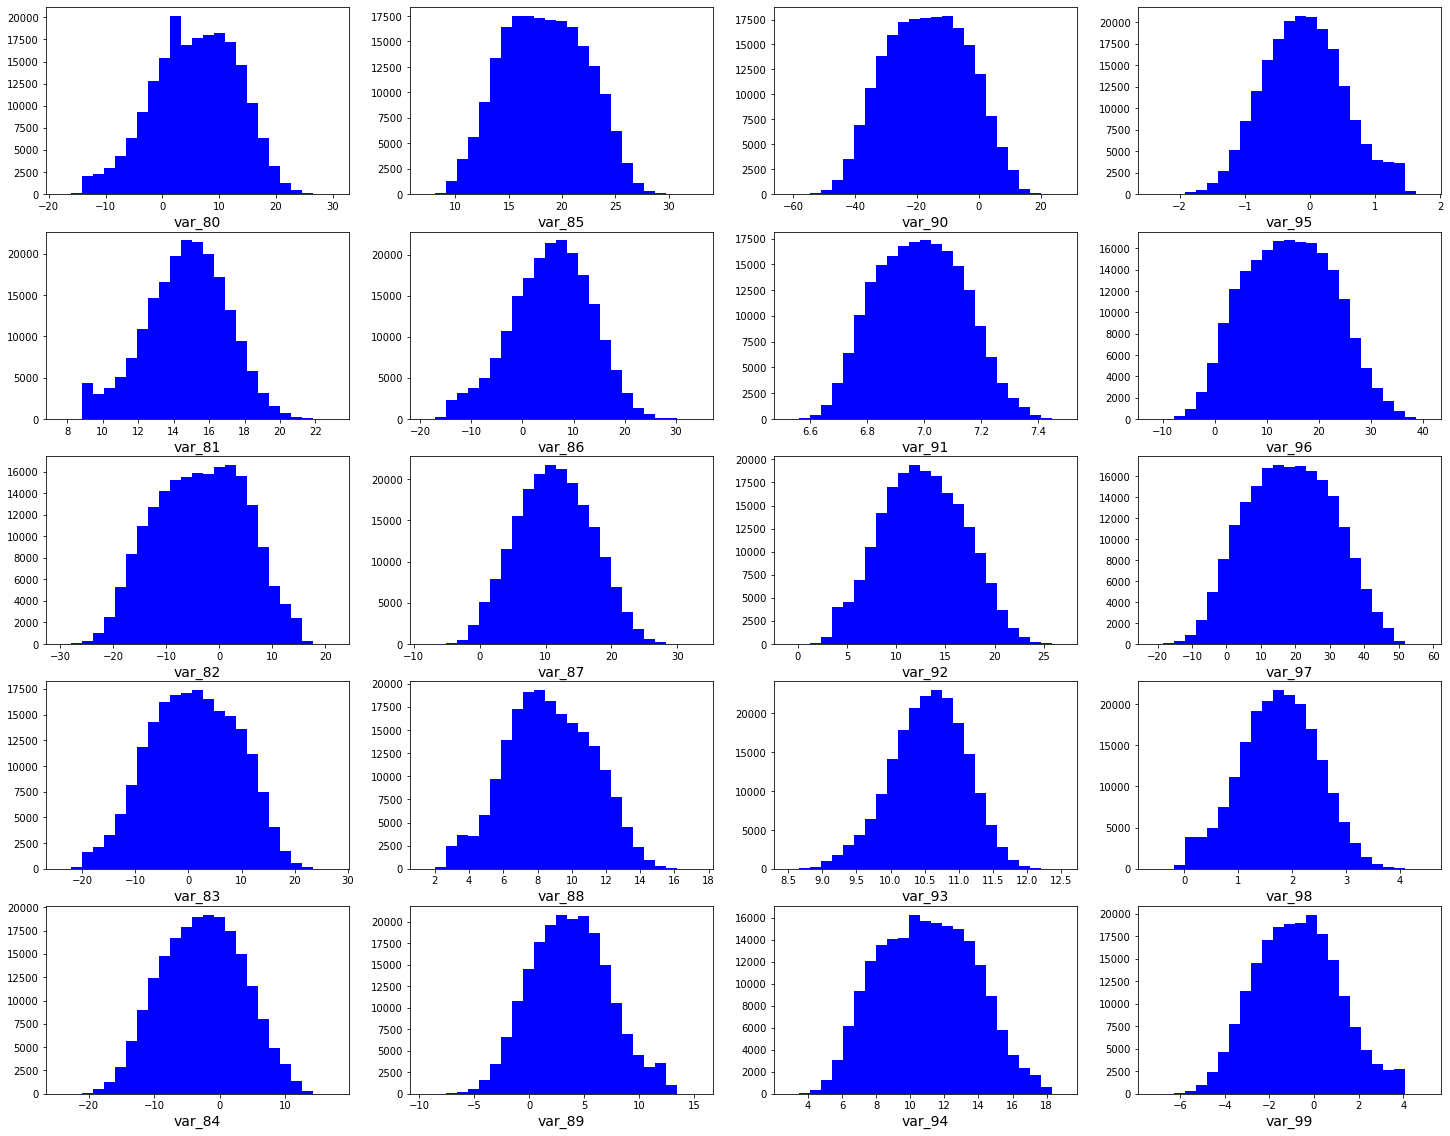

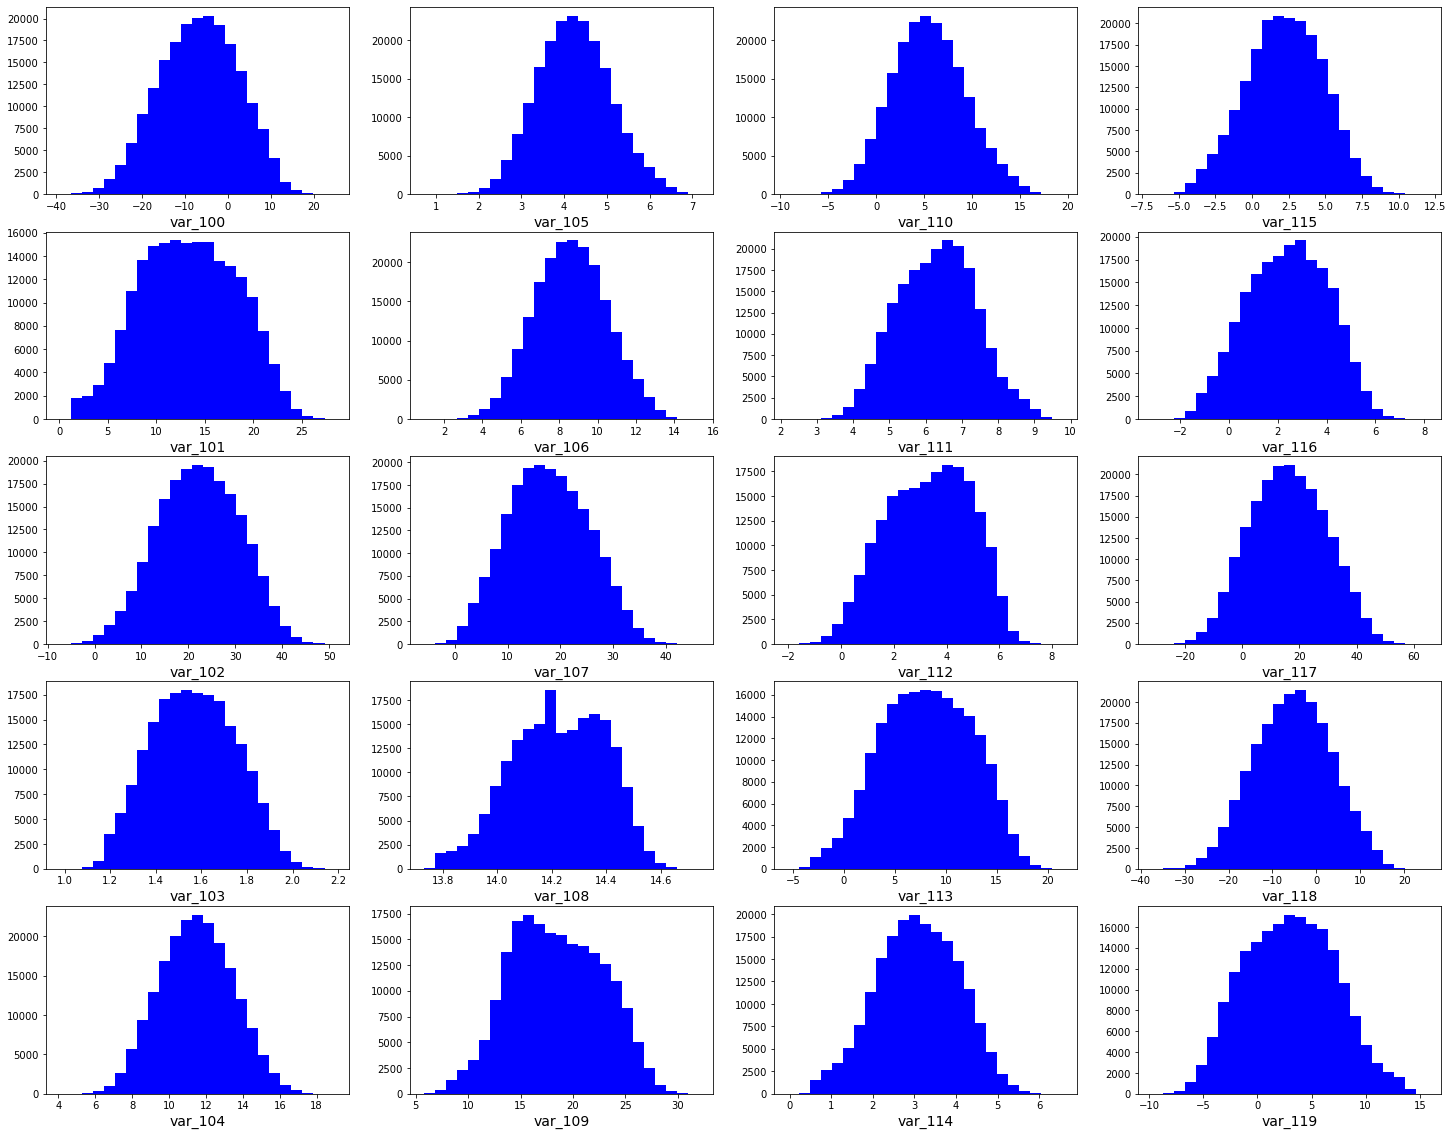

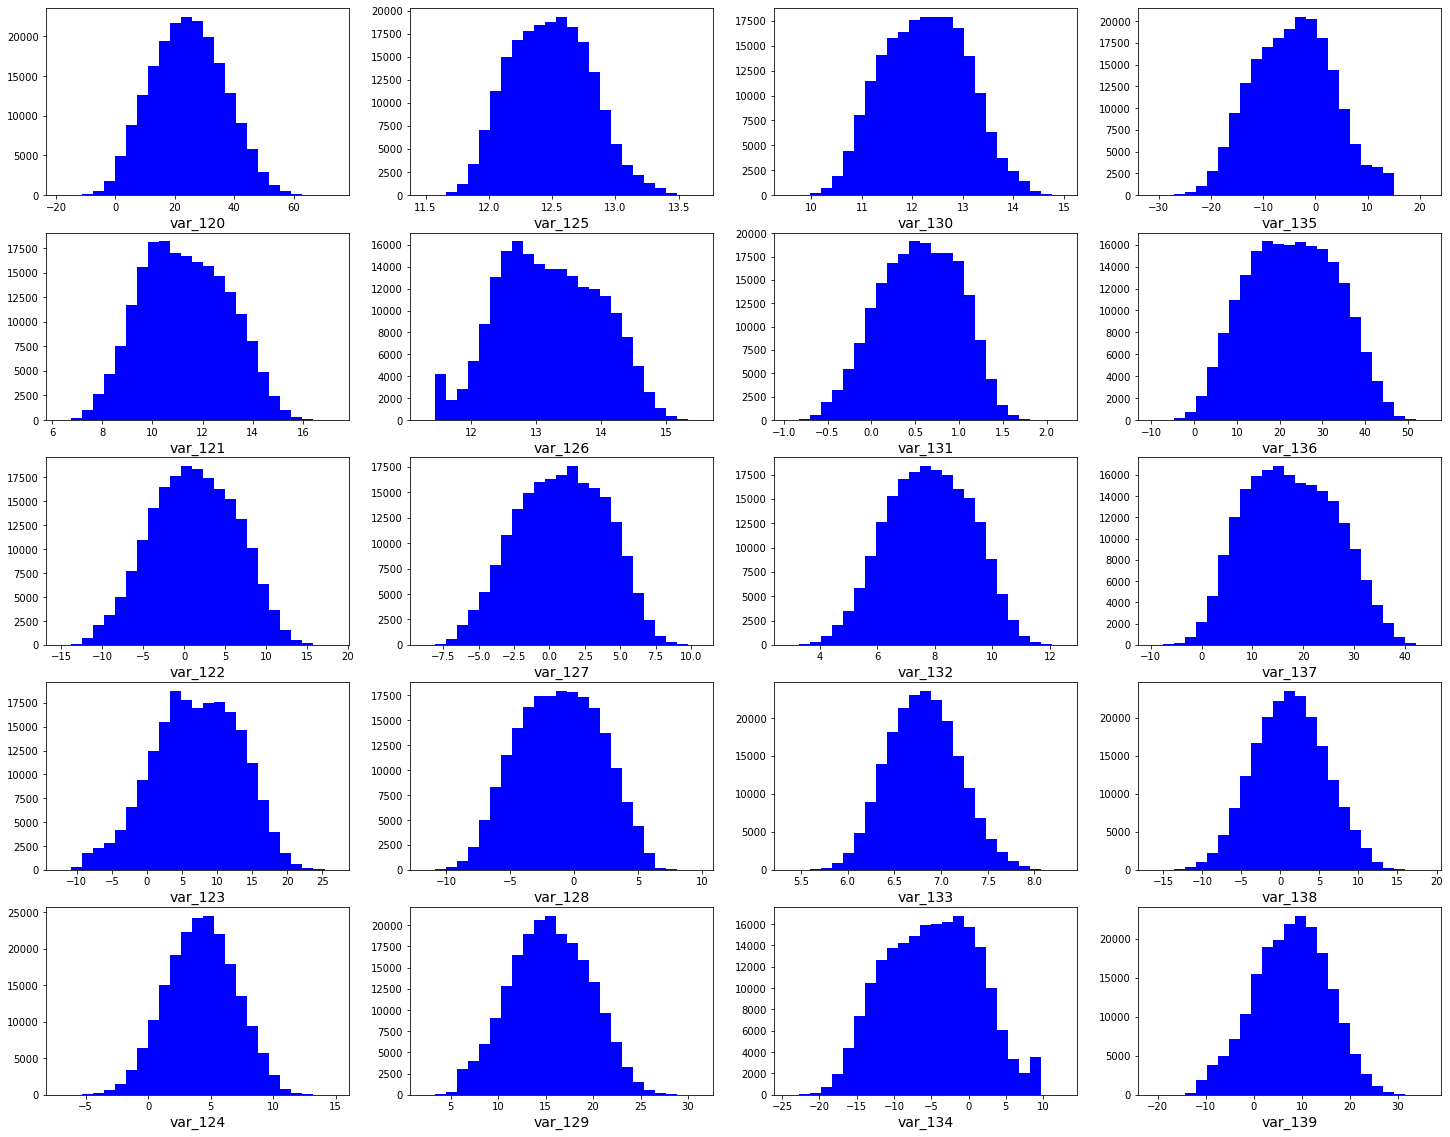

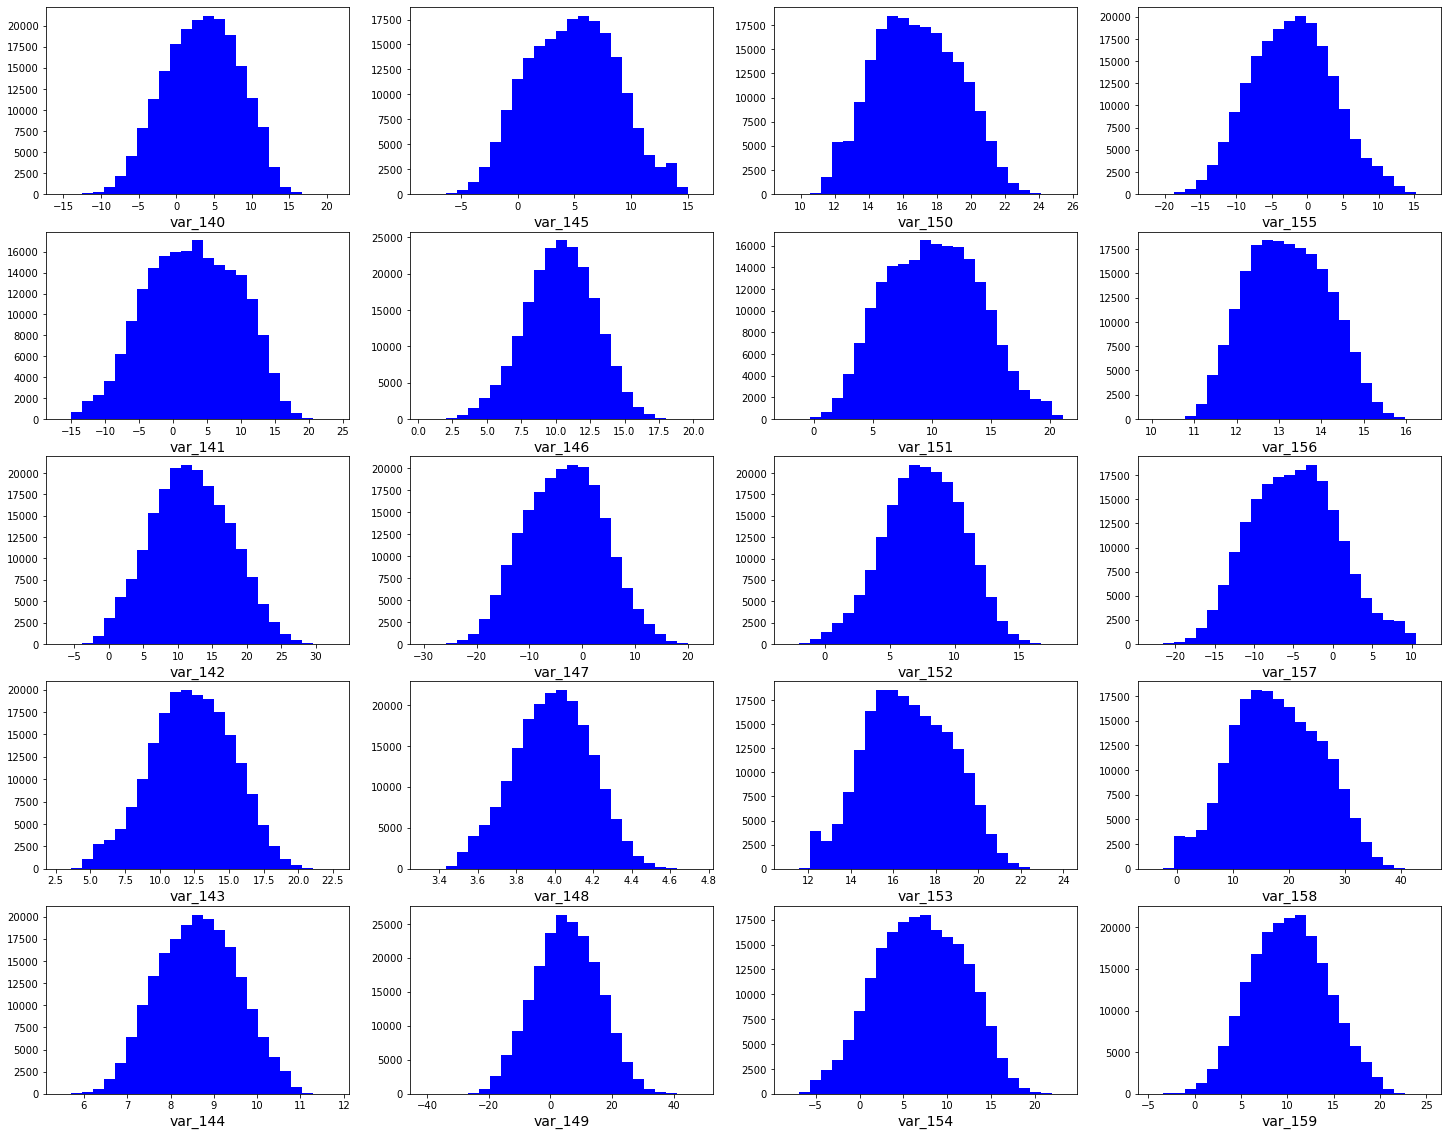

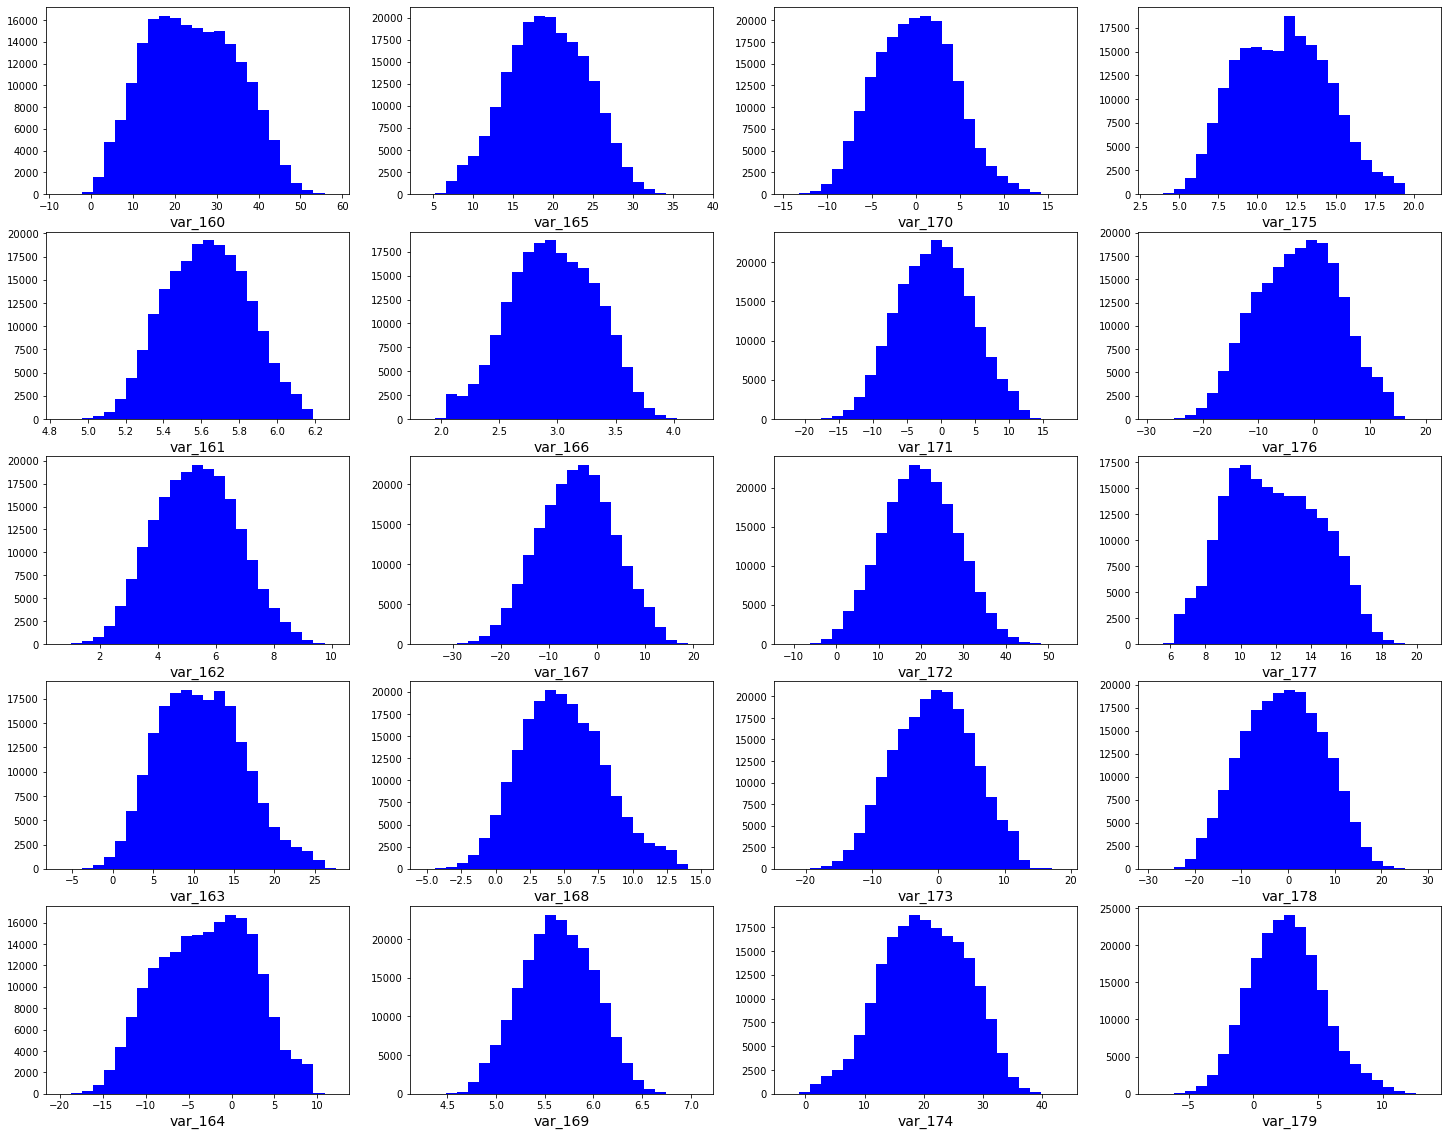

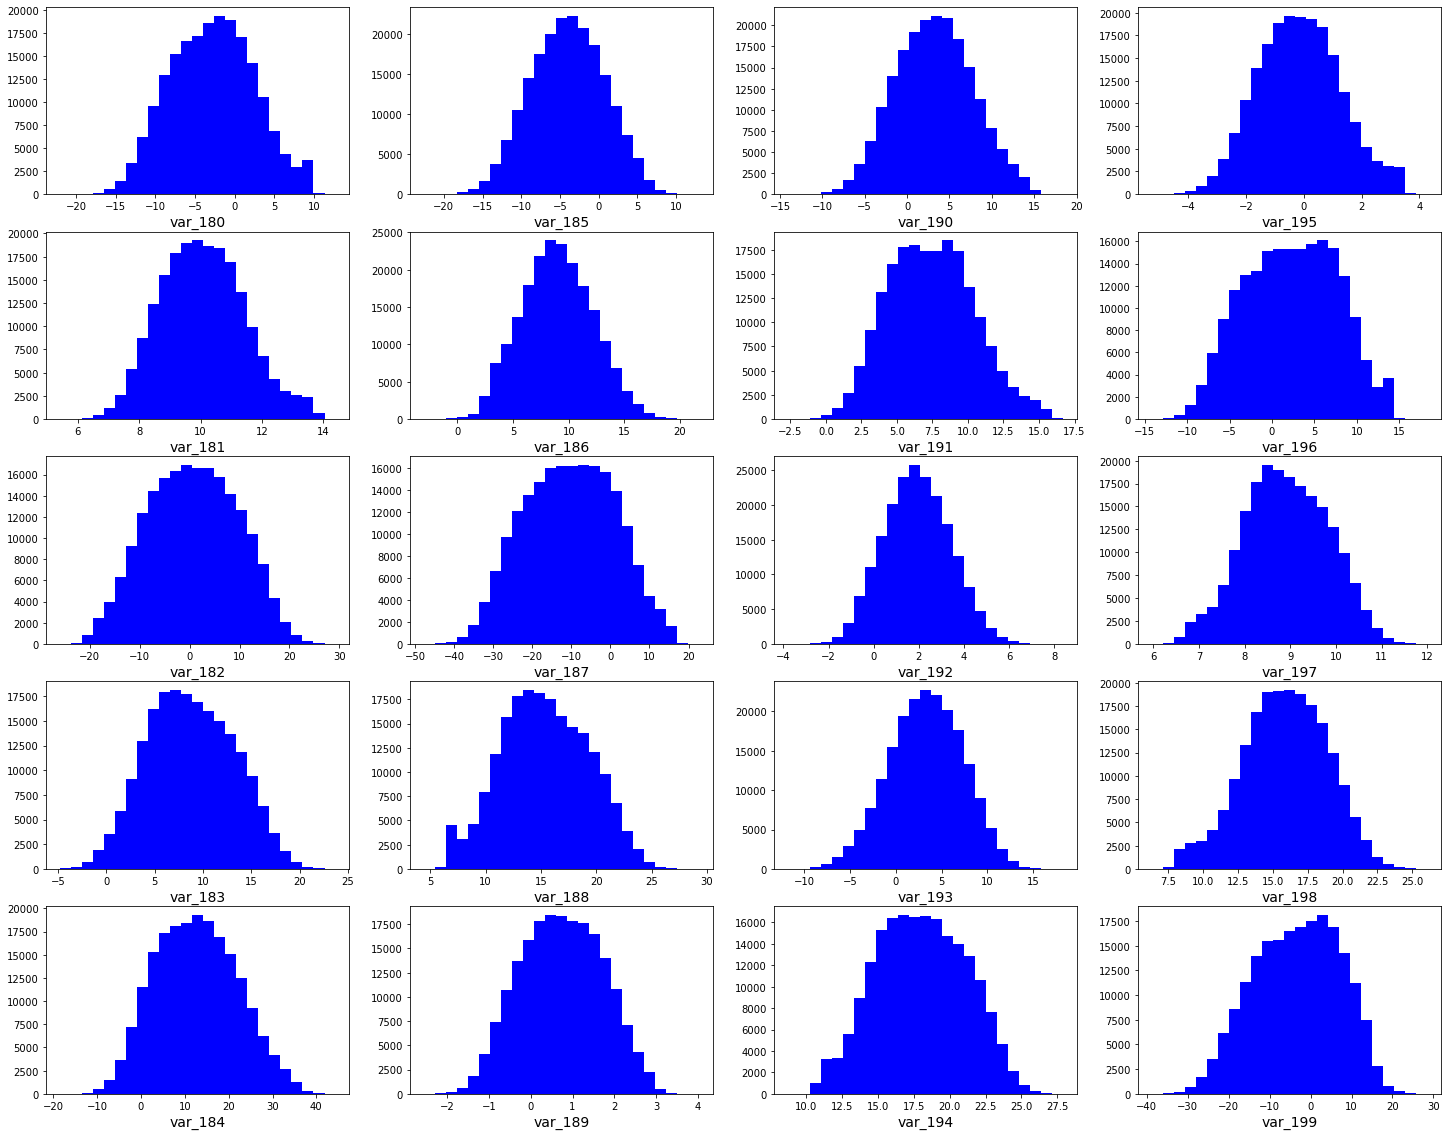

In [12]:
g = group(continuous_feature, 20)

for i in g:
    fig, axes = plt.subplots(5, 4, figsize=(25, 20))
    for num, feature in enumerate(list(i)):
        data = train[feature].copy()
        axes[num%5, num//5].hist(data, bins=25, color="blue")
        axes[num%5, num//5].set_xlabel(feature, fontsize=14)  

Признаки распределены нормально с небольшими отклонениями.

<AxesSubplot:>

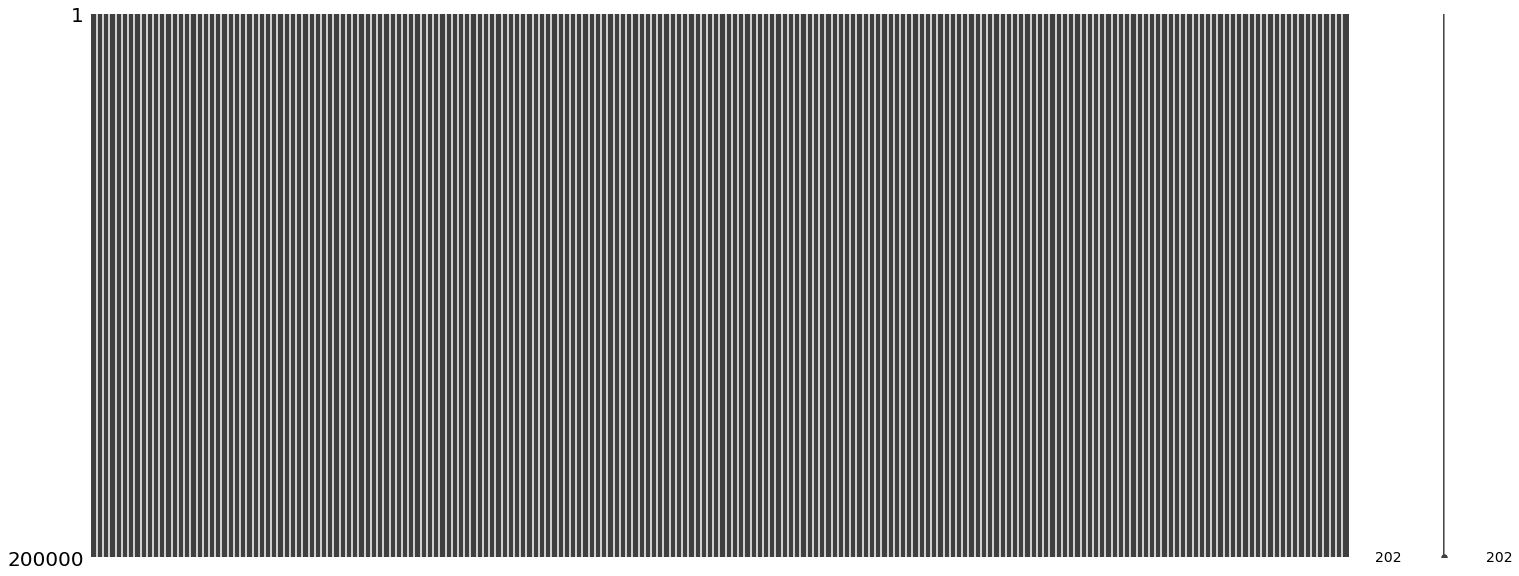

In [13]:
msno.matrix(train)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


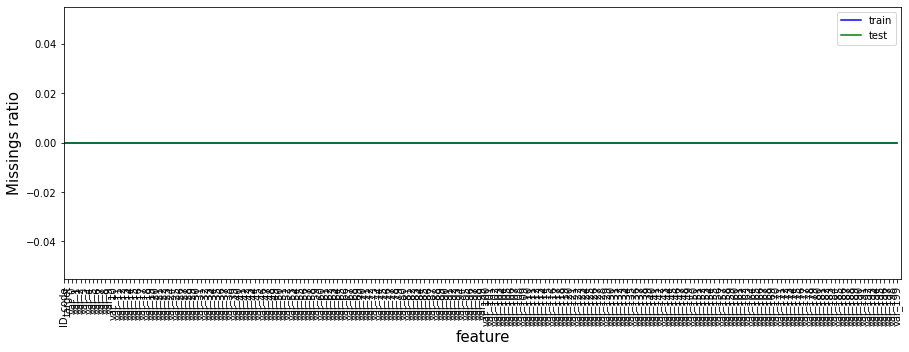

In [15]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train.isnull().mean(), label="train", color="blue")
plt.plot(test.isnull().mean(), label="test", color="green")
plt.xticks(range(train.shape[1]), train.columns, rotation=90)
plt.ylabel("Missings ratio", size=15)
plt.xlabel("feature", size=15)
plt.xlim(0, train.shape[1])
plt.legend(loc="best")

Пропусков не обнаружено

## Задание 2: Сделать базовый анализ целевой переменной, сделать выводы;

In [16]:
target = train["target"]
target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

Целевая переменная представлена только числами 1 и 0. С преобладанием 0.

## Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

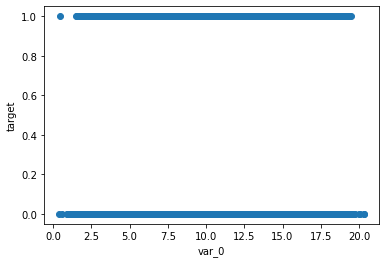

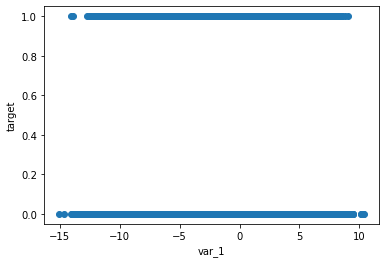

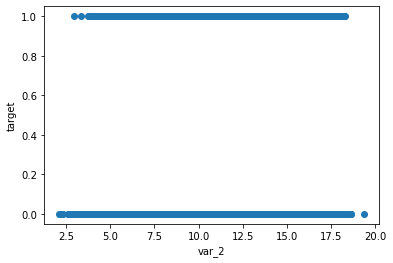

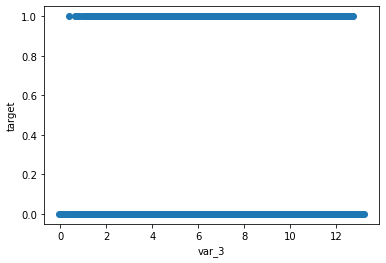

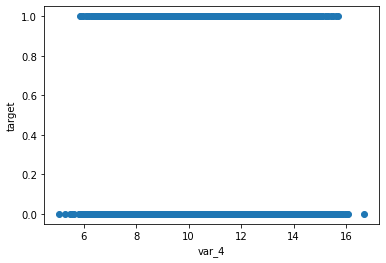

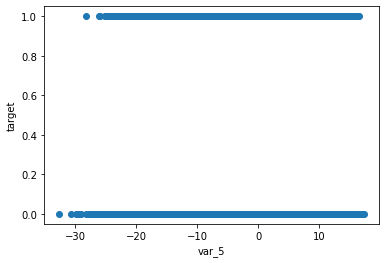

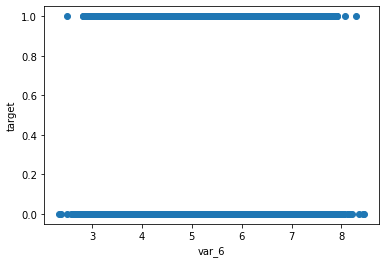

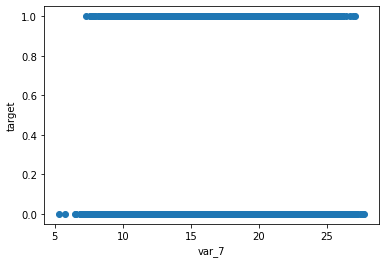

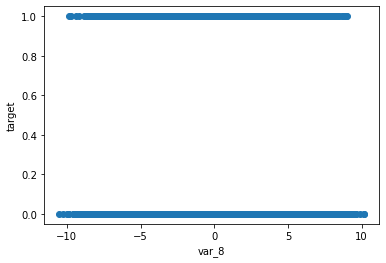

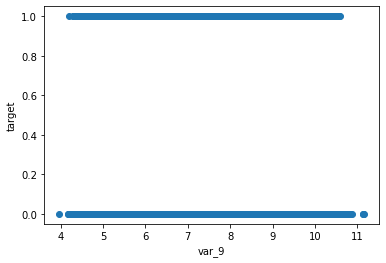

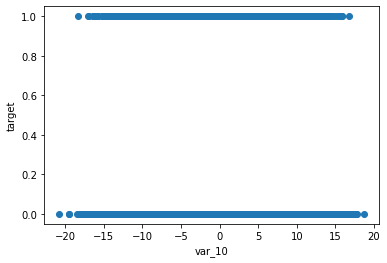

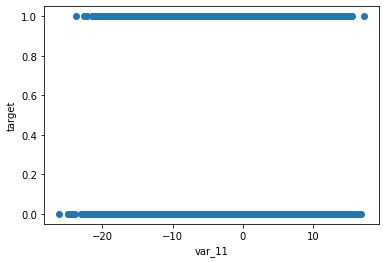

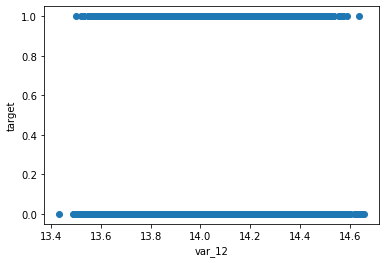

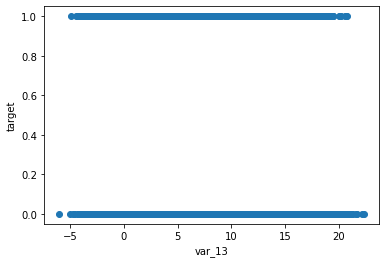

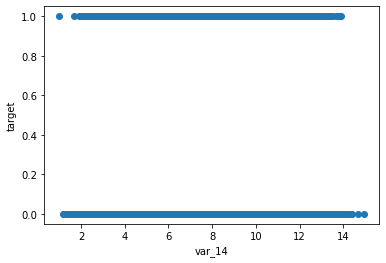

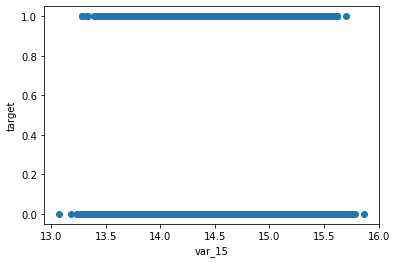

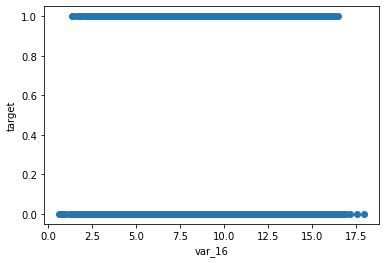

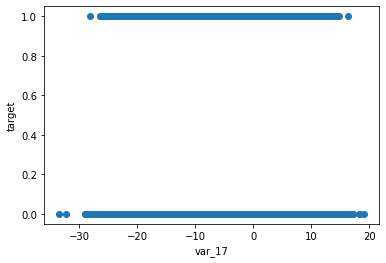

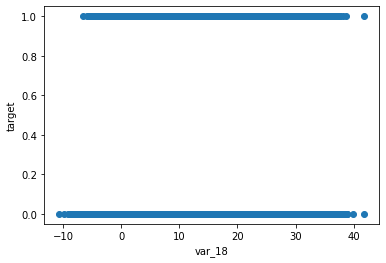

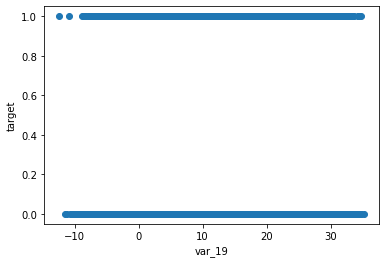

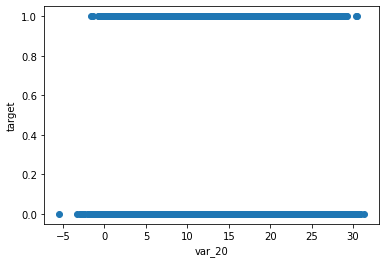

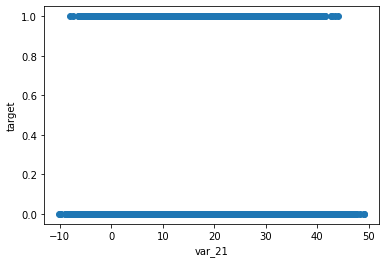

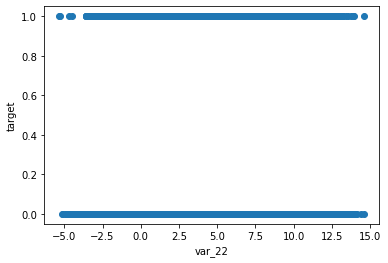

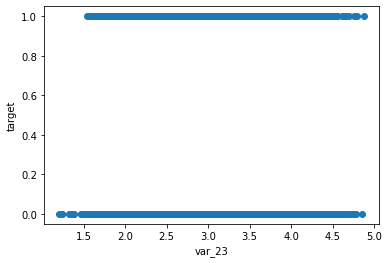

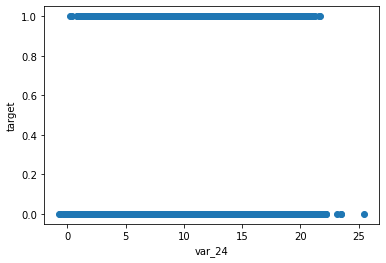

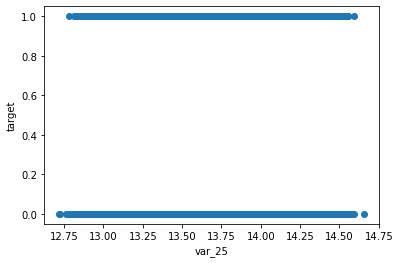

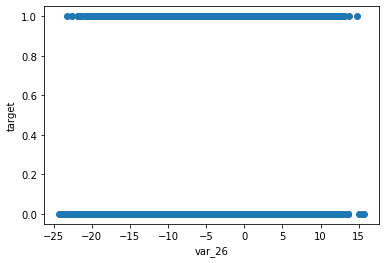

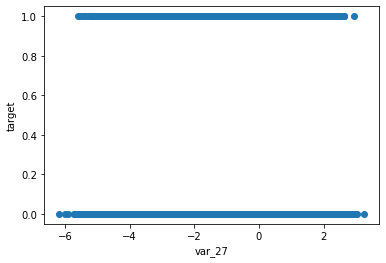

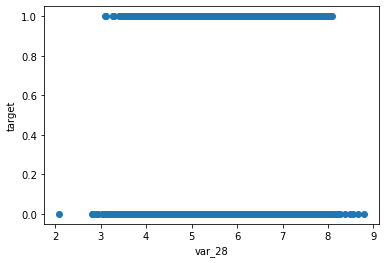

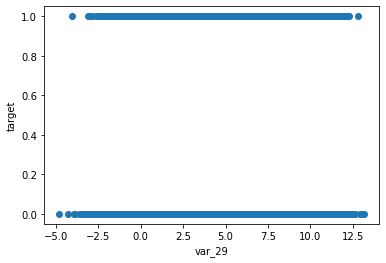

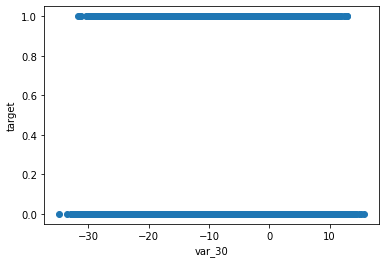

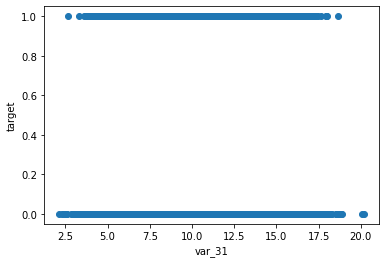

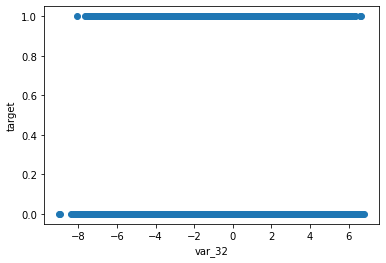

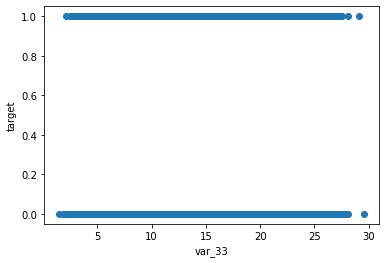

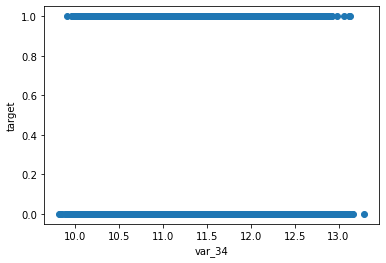

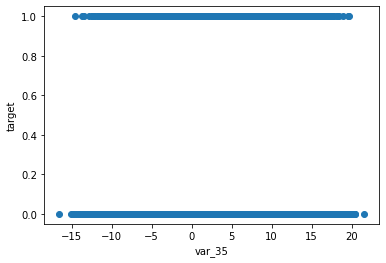

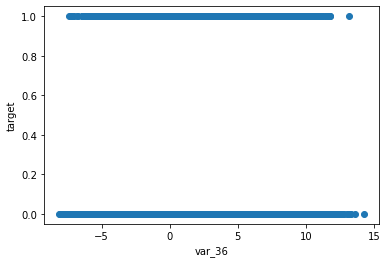

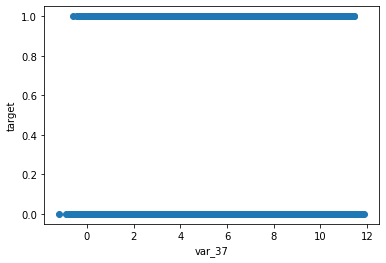

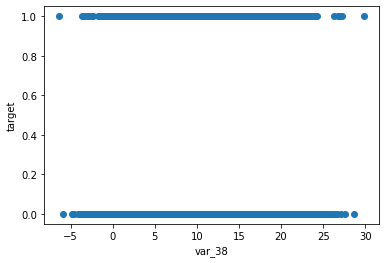

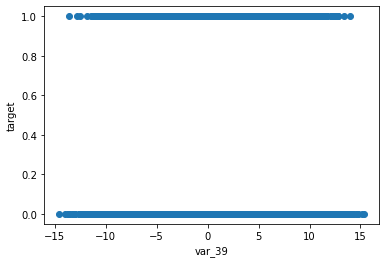

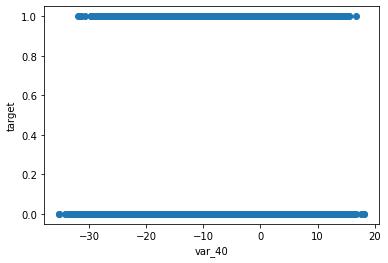

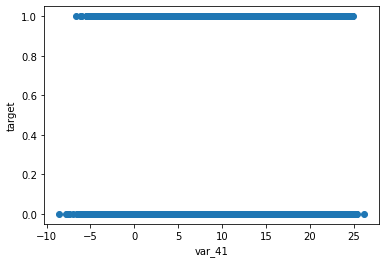

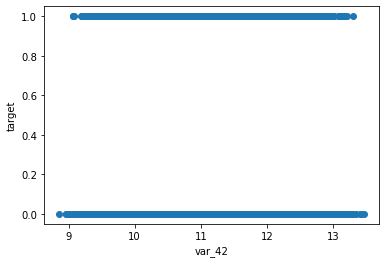

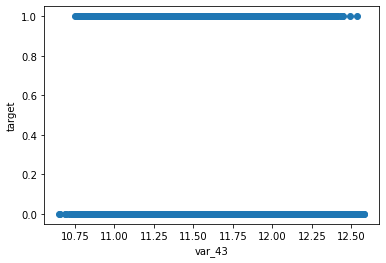

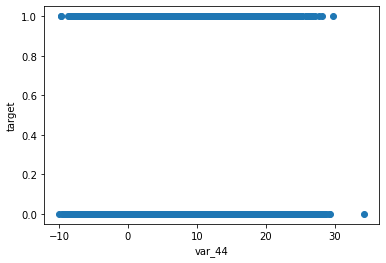

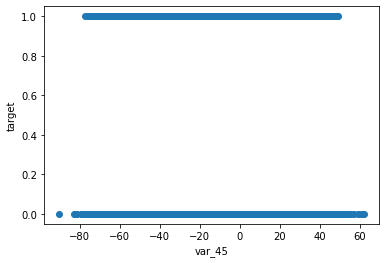

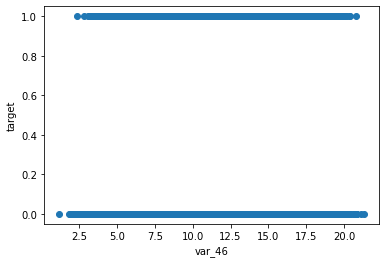

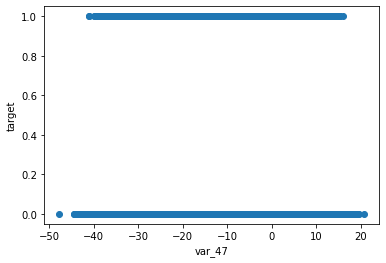

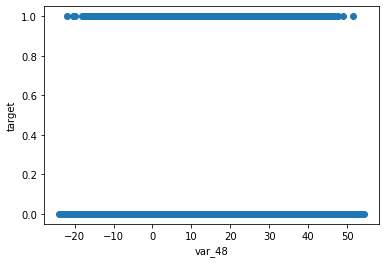

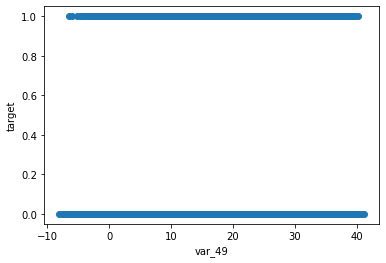

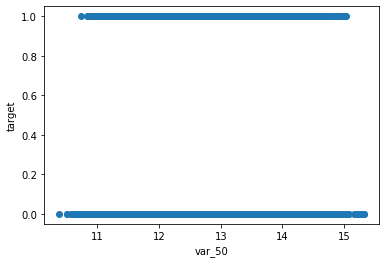

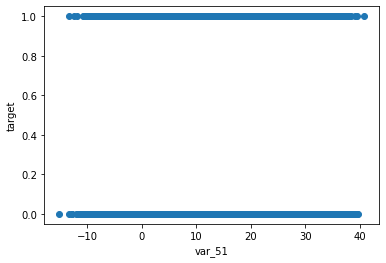

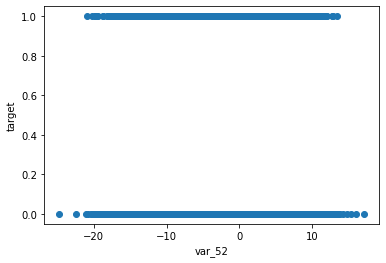

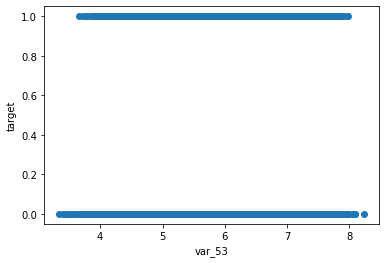

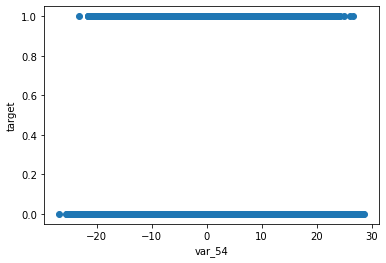

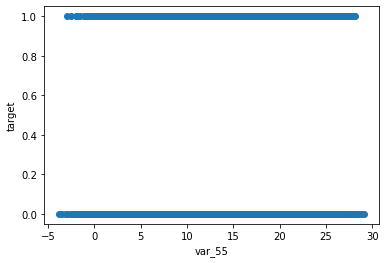

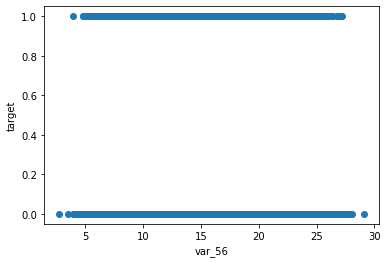

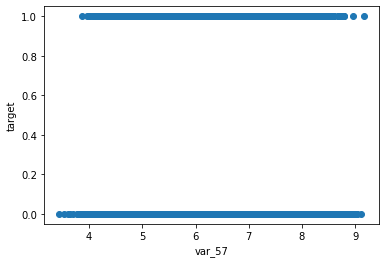

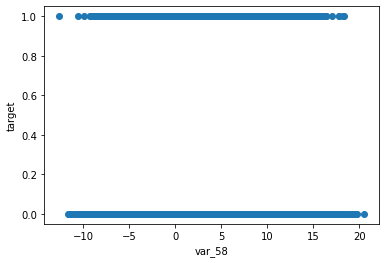

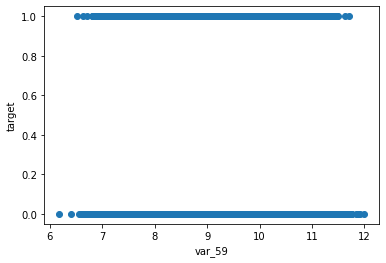

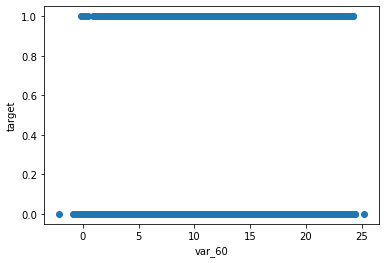

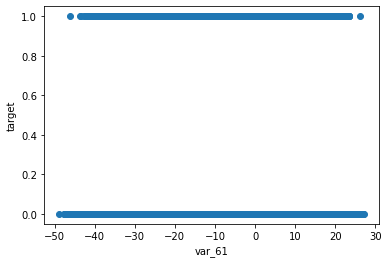

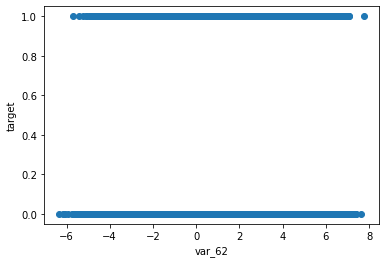

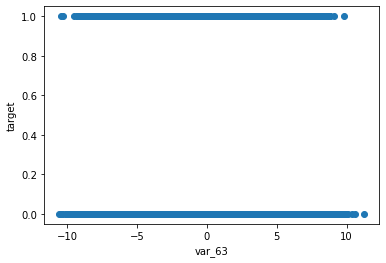

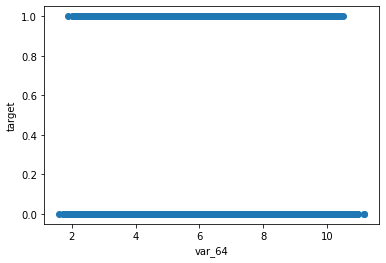

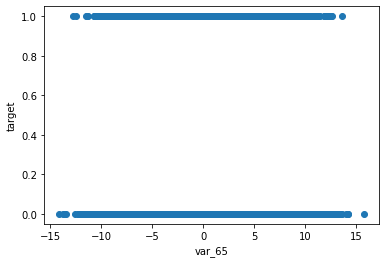

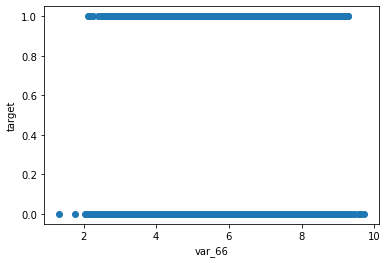

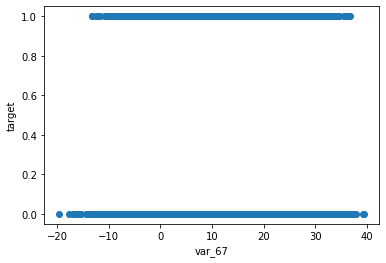

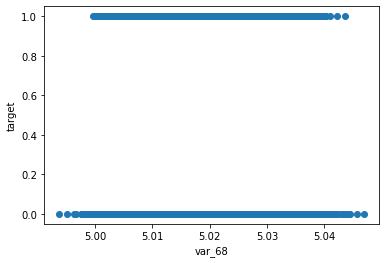

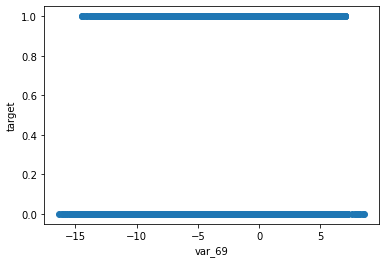

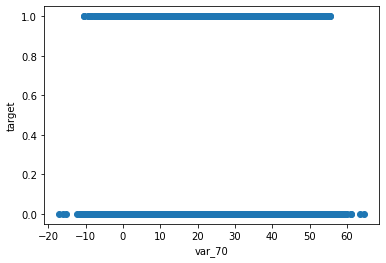

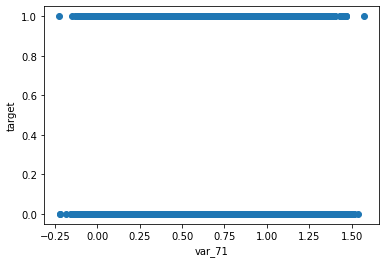

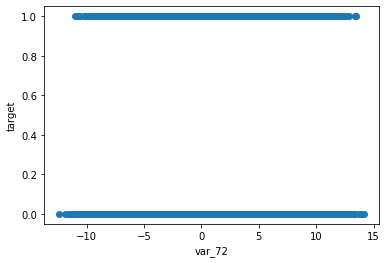

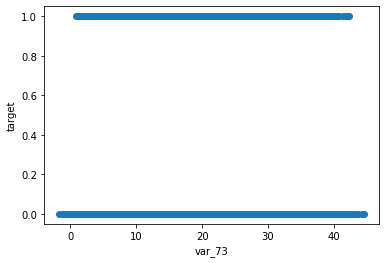

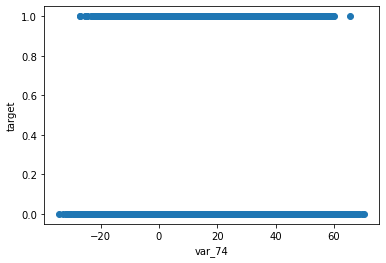

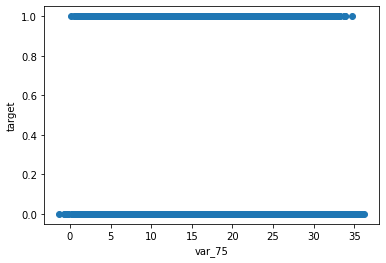

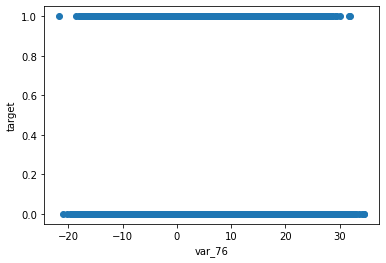

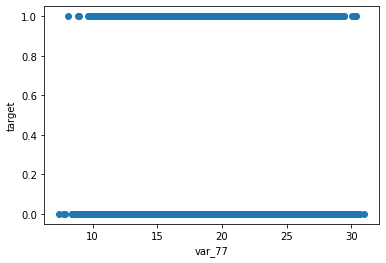

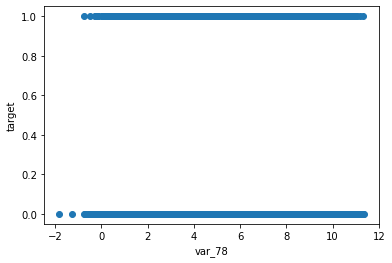

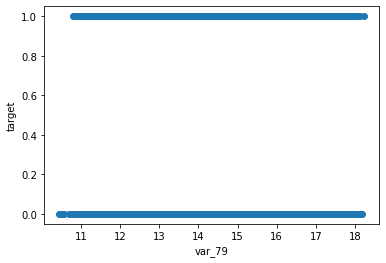

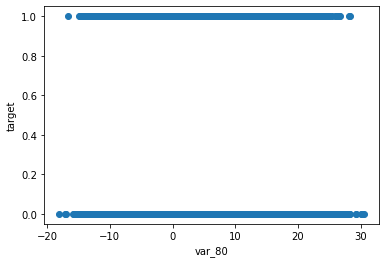

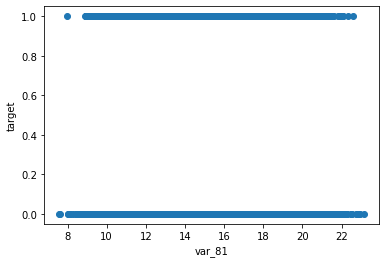

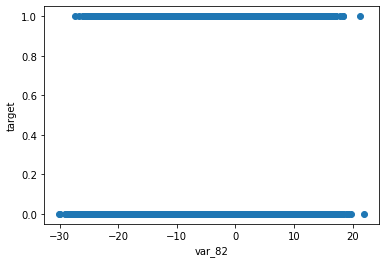

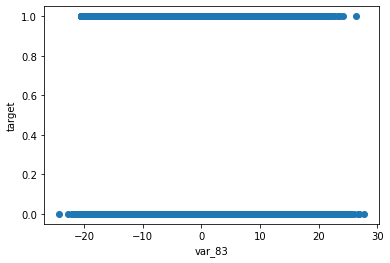

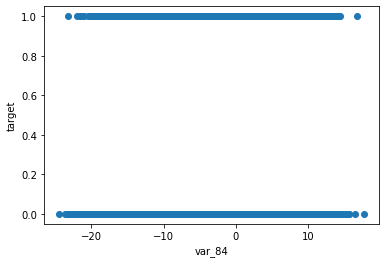

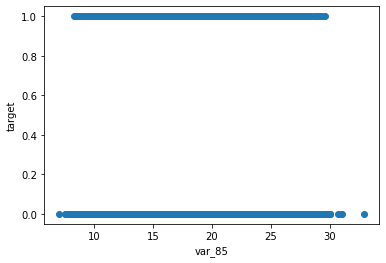

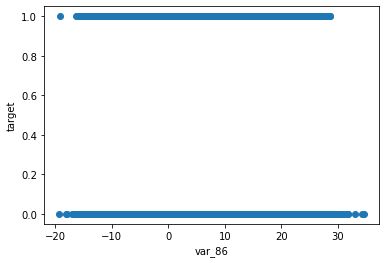

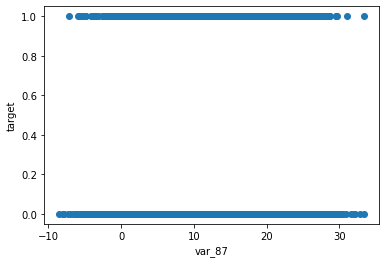

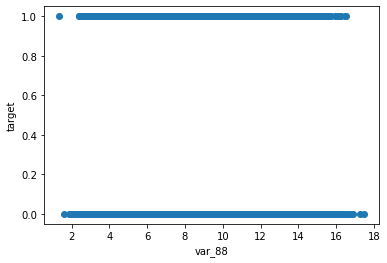

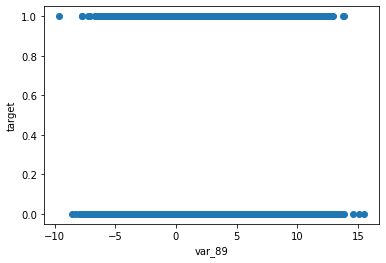

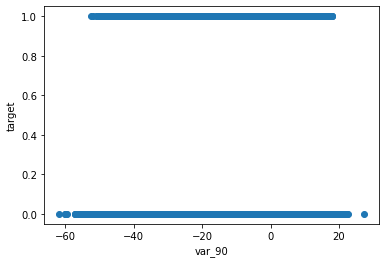

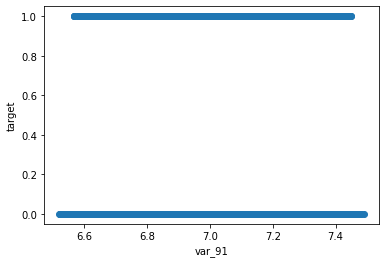

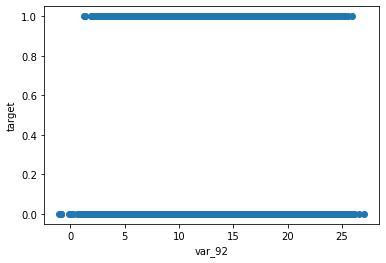

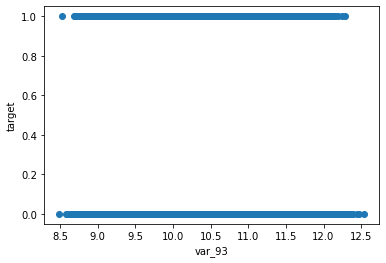

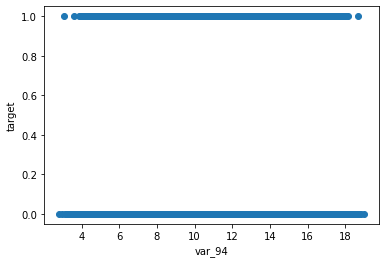

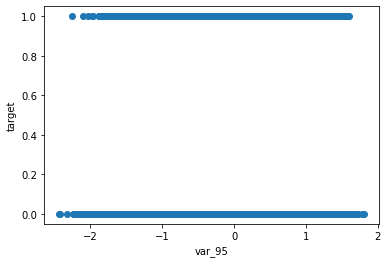

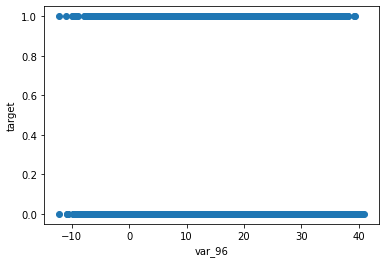

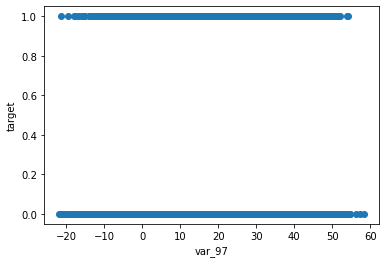

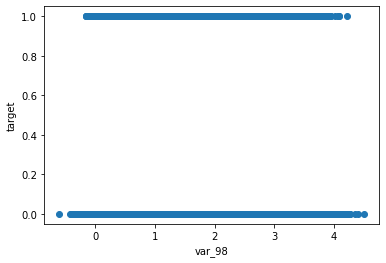

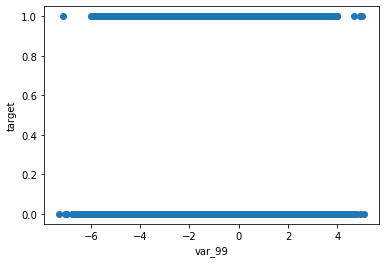

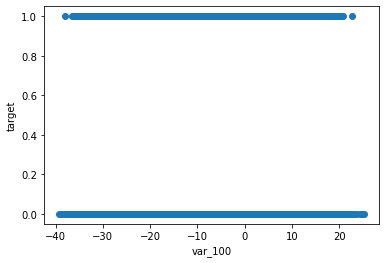

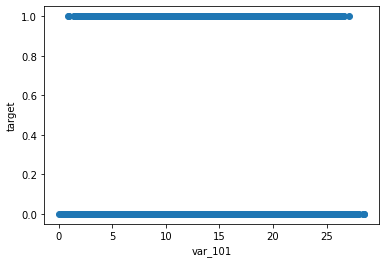

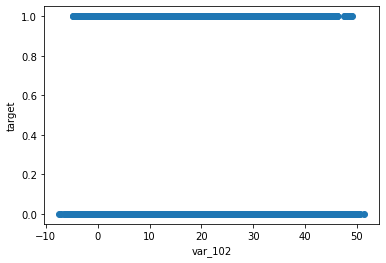

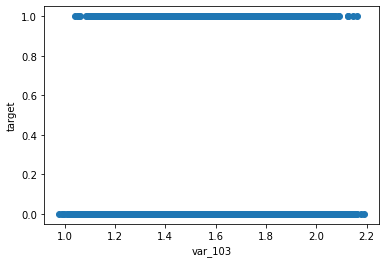

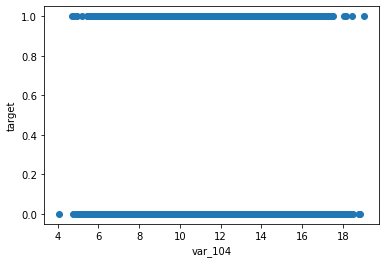

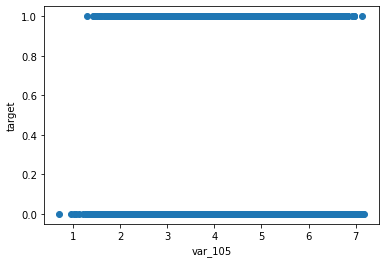

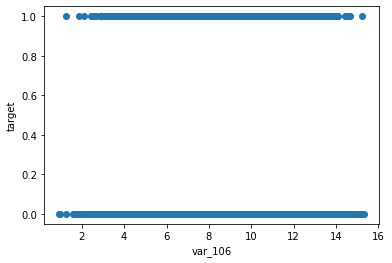

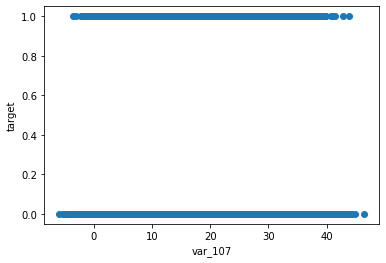

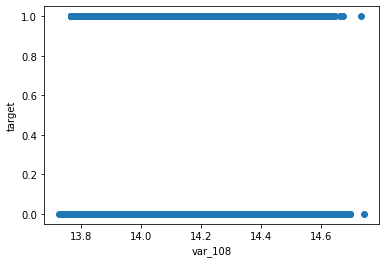

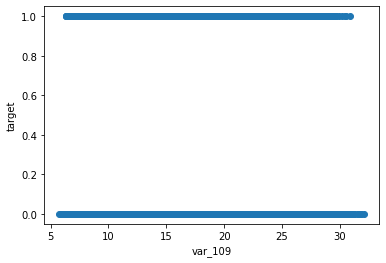

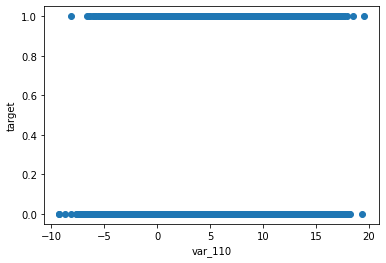

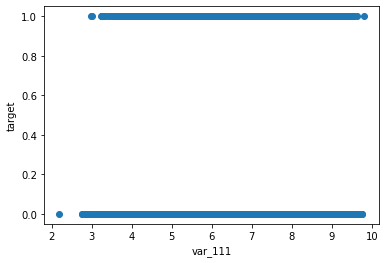

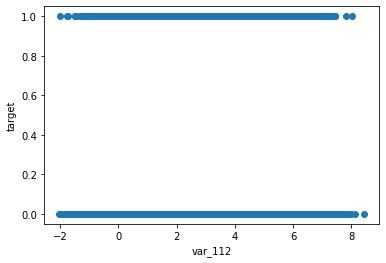

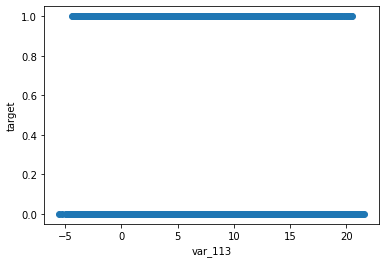

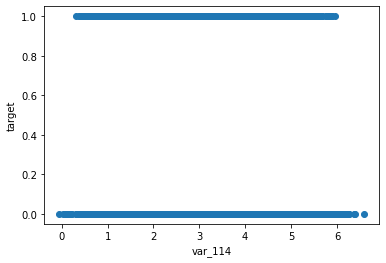

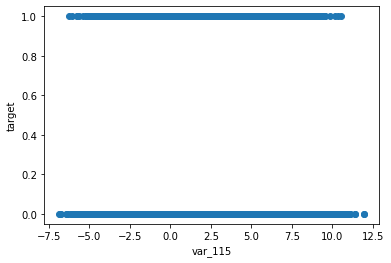

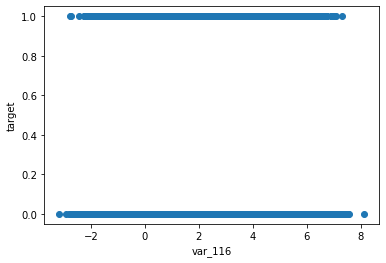

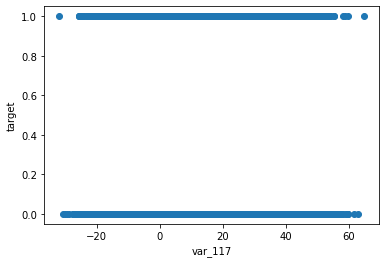

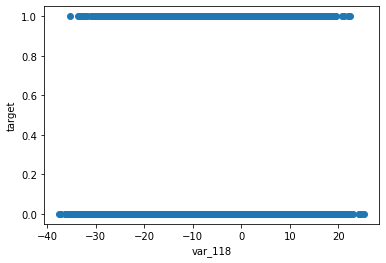

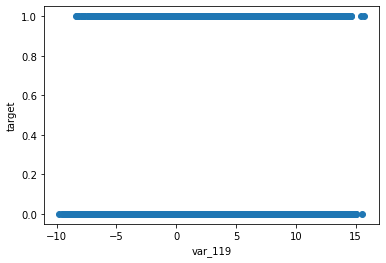

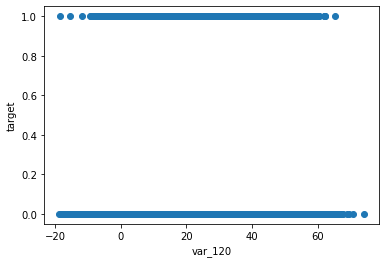

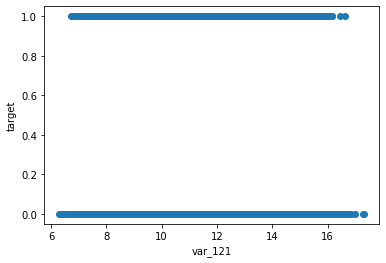

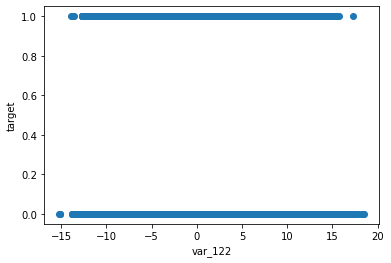

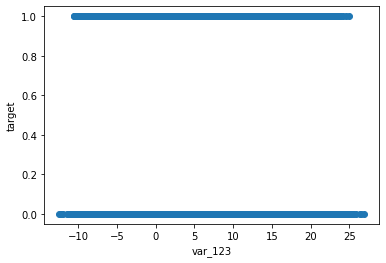

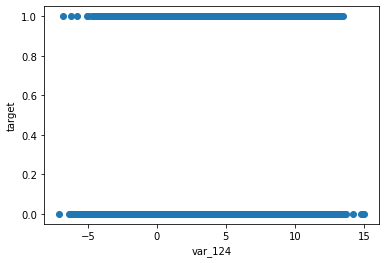

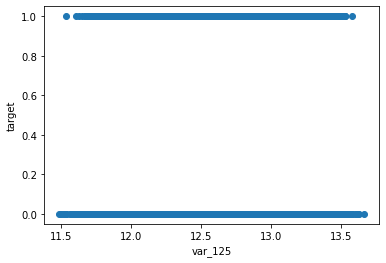

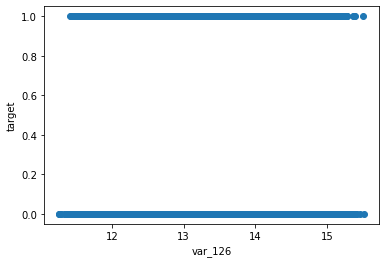

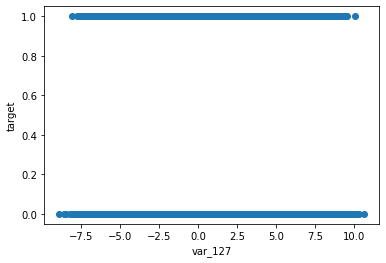

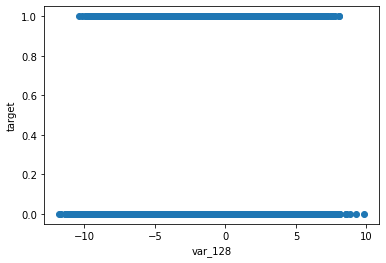

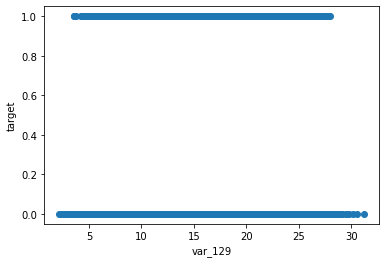

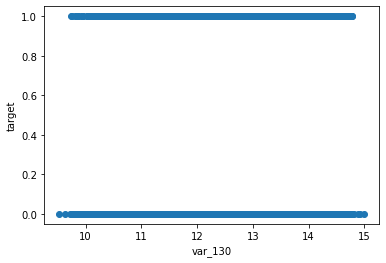

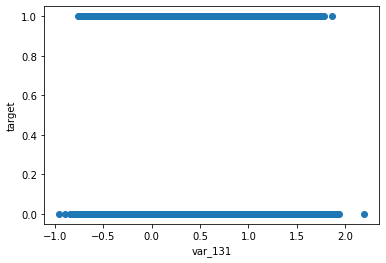

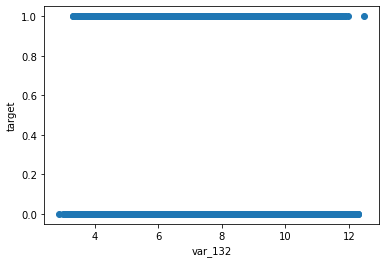

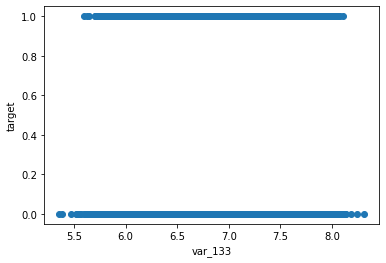

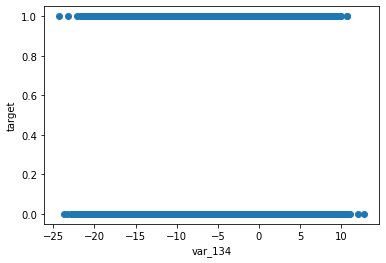

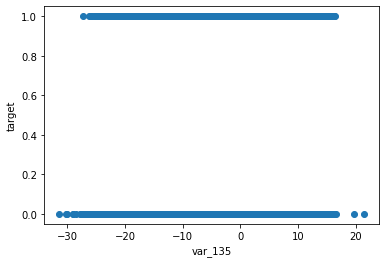

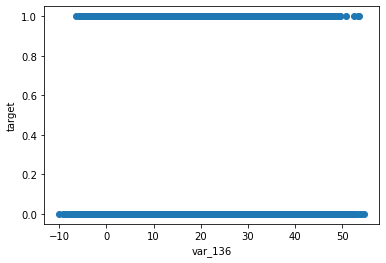

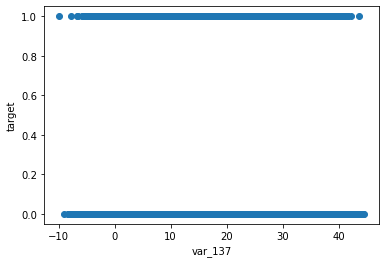

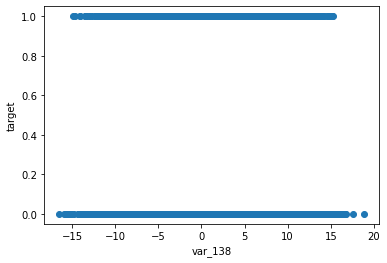

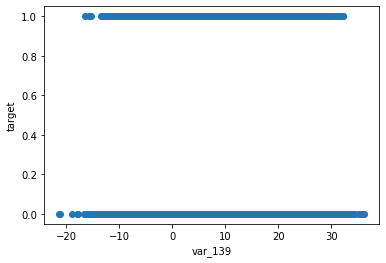

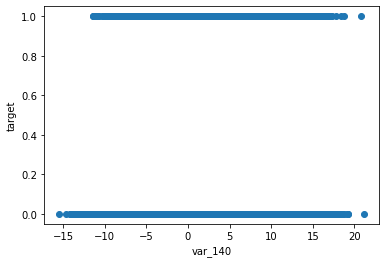

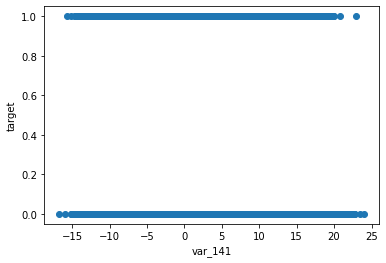

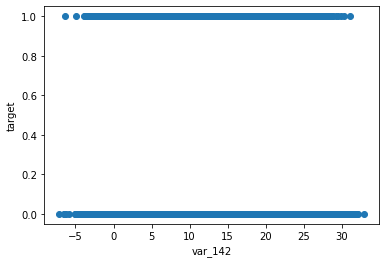

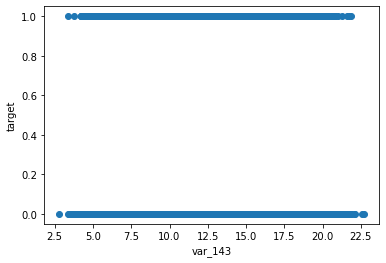

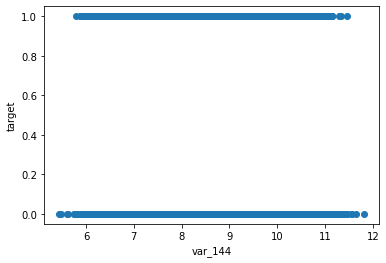

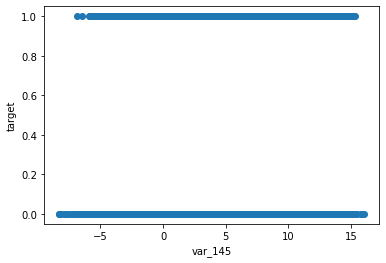

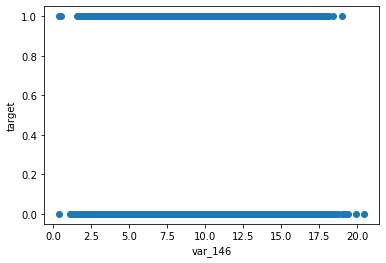

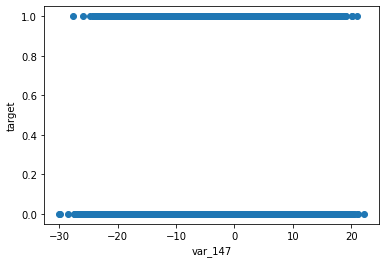

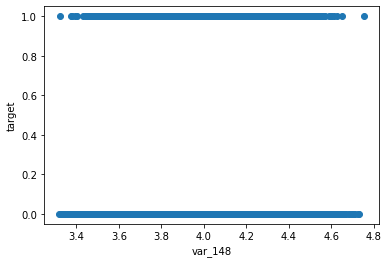

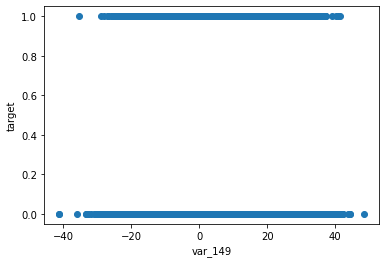

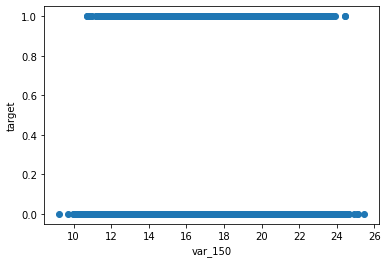

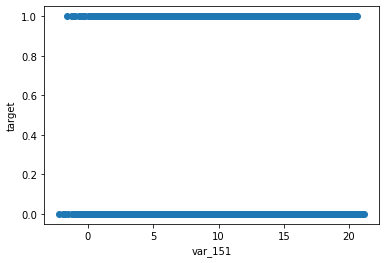

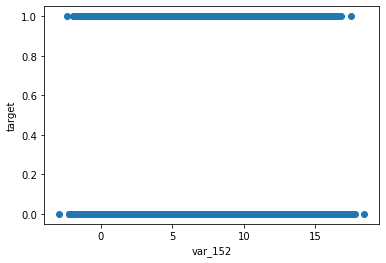

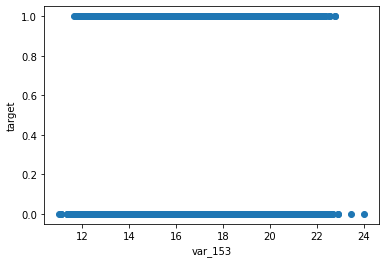

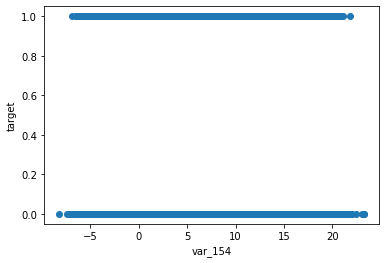

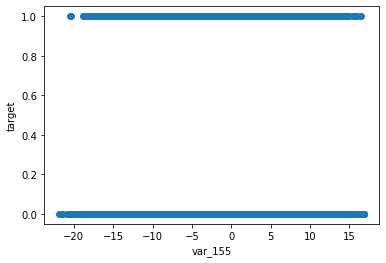

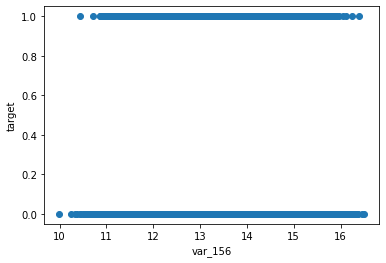

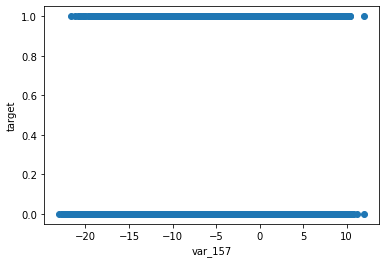

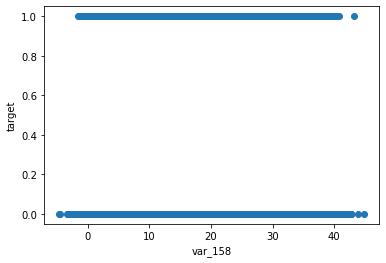

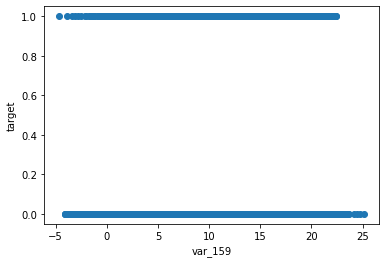

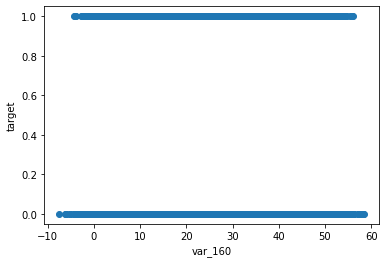

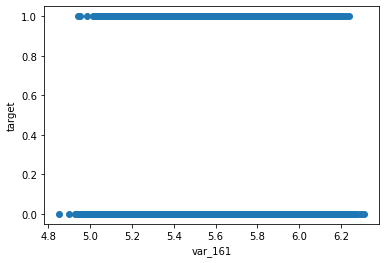

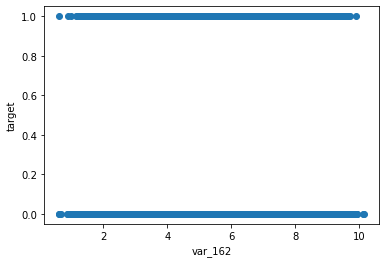

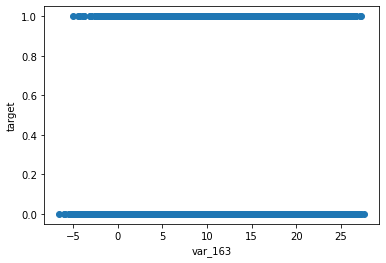

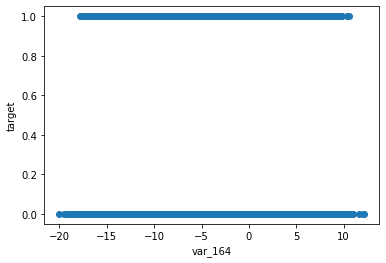

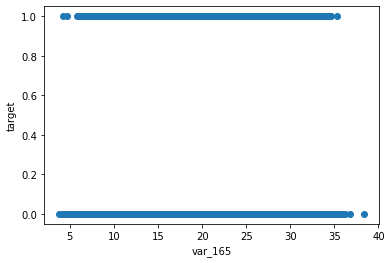

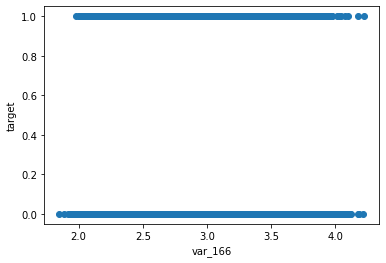

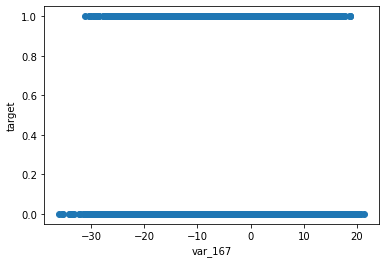

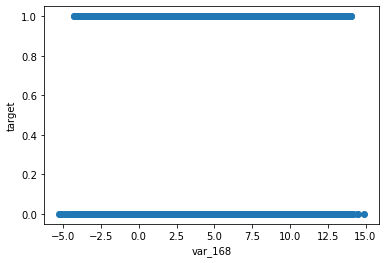

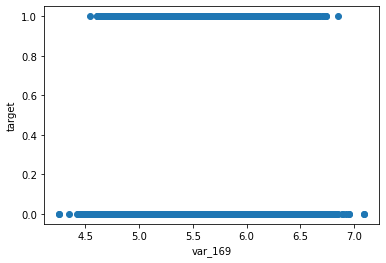

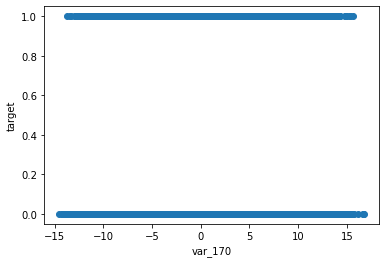

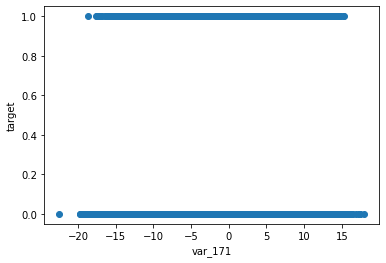

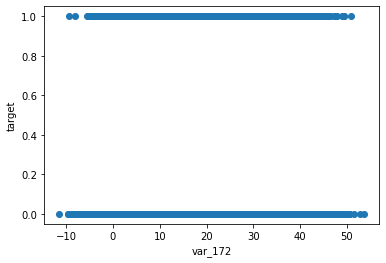

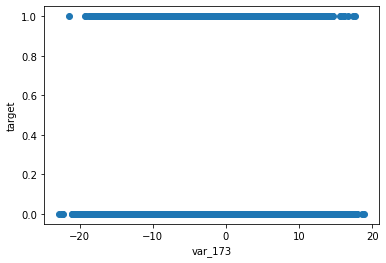

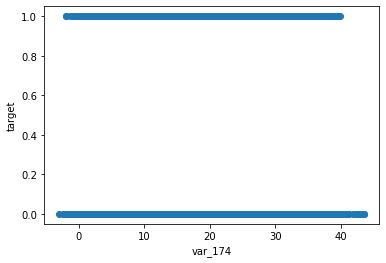

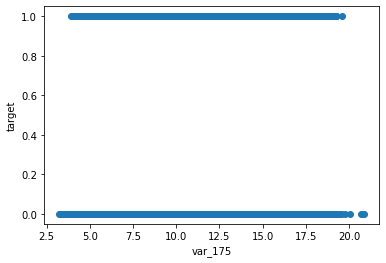

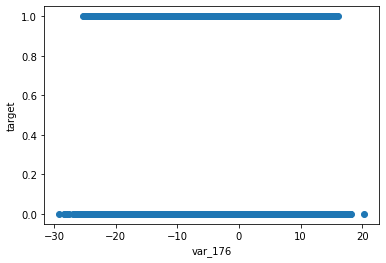

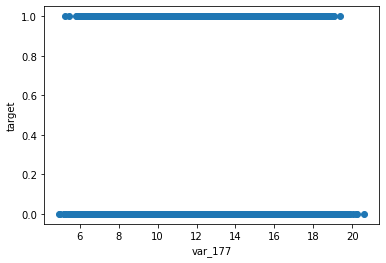

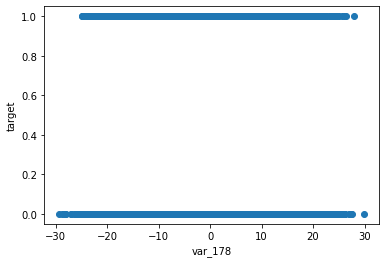

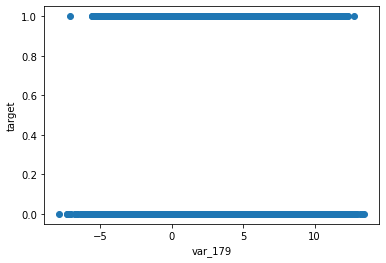

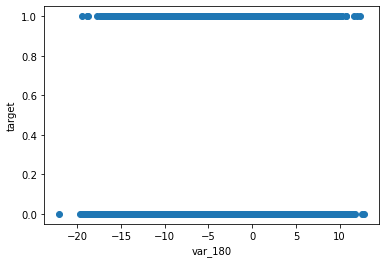

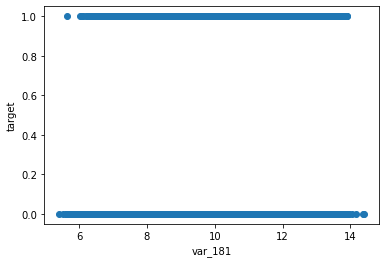

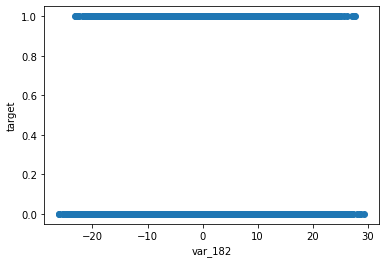

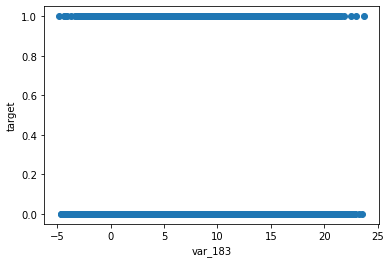

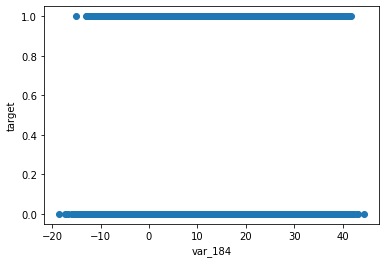

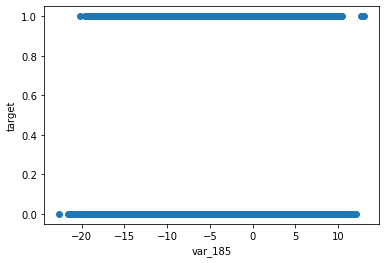

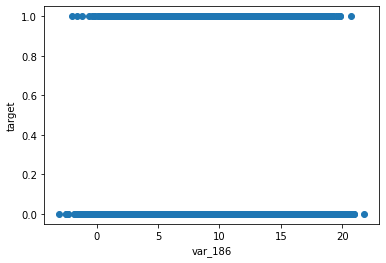

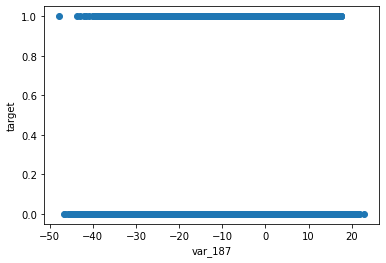

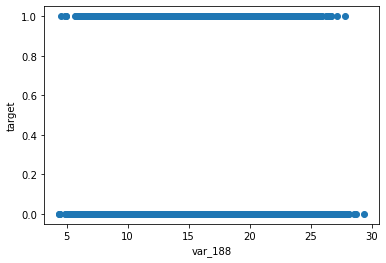

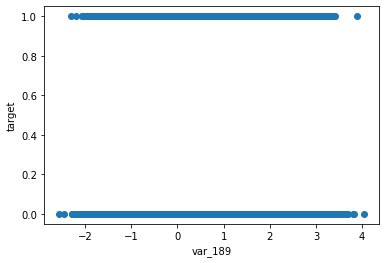

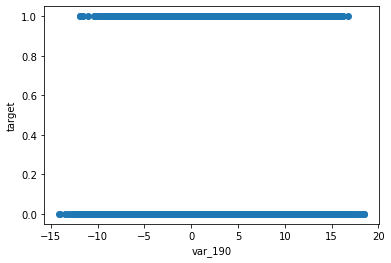

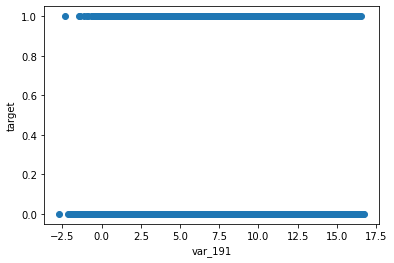

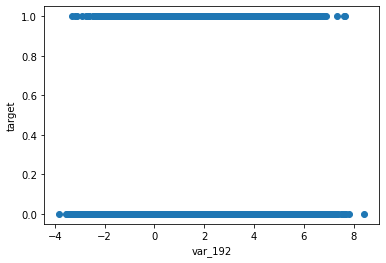

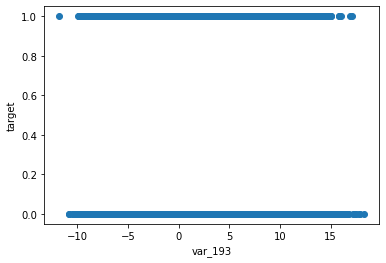

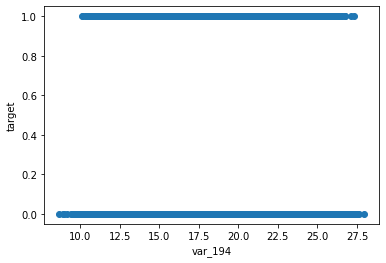

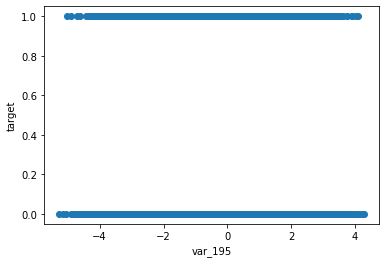

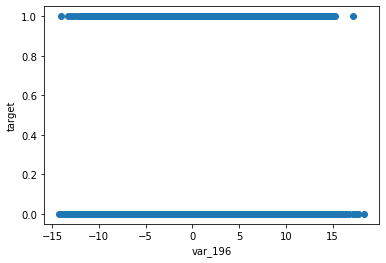

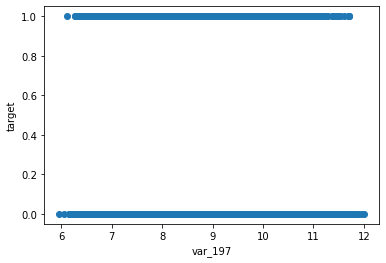

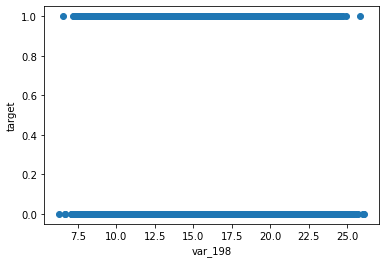

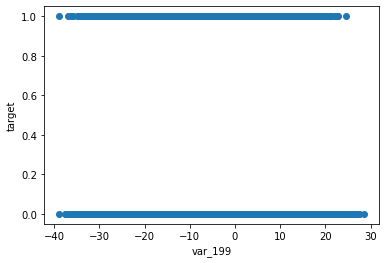

In [21]:
for num, feature in enumerate(continuous_feature):
    plt.scatter(train[feature], train['target']) 
    plt.xlabel(feature)
    plt.ylabel('target')
    plt.show()

C:\Users\raben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\raben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\raben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:title={'center':'Log Normal'}, xlabel='target'>

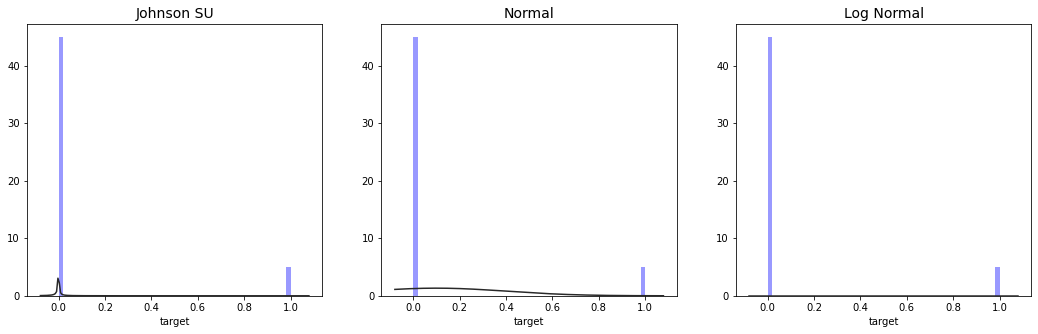

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.lognorm, ax=axes[2])

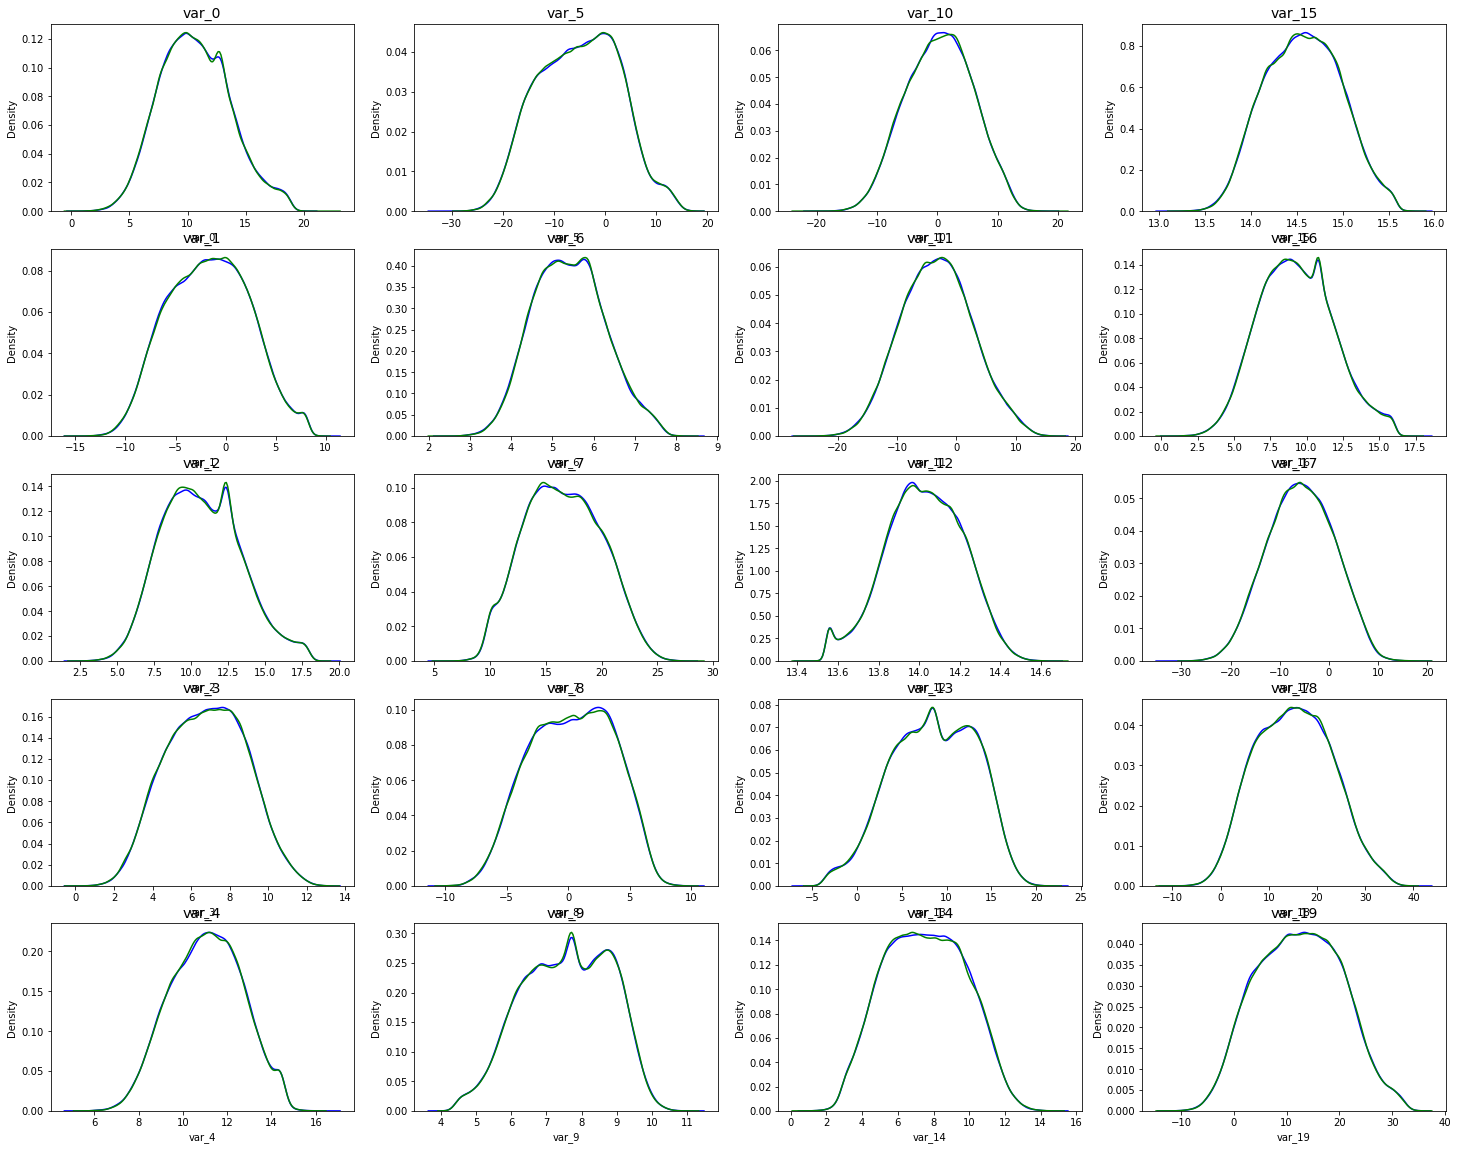

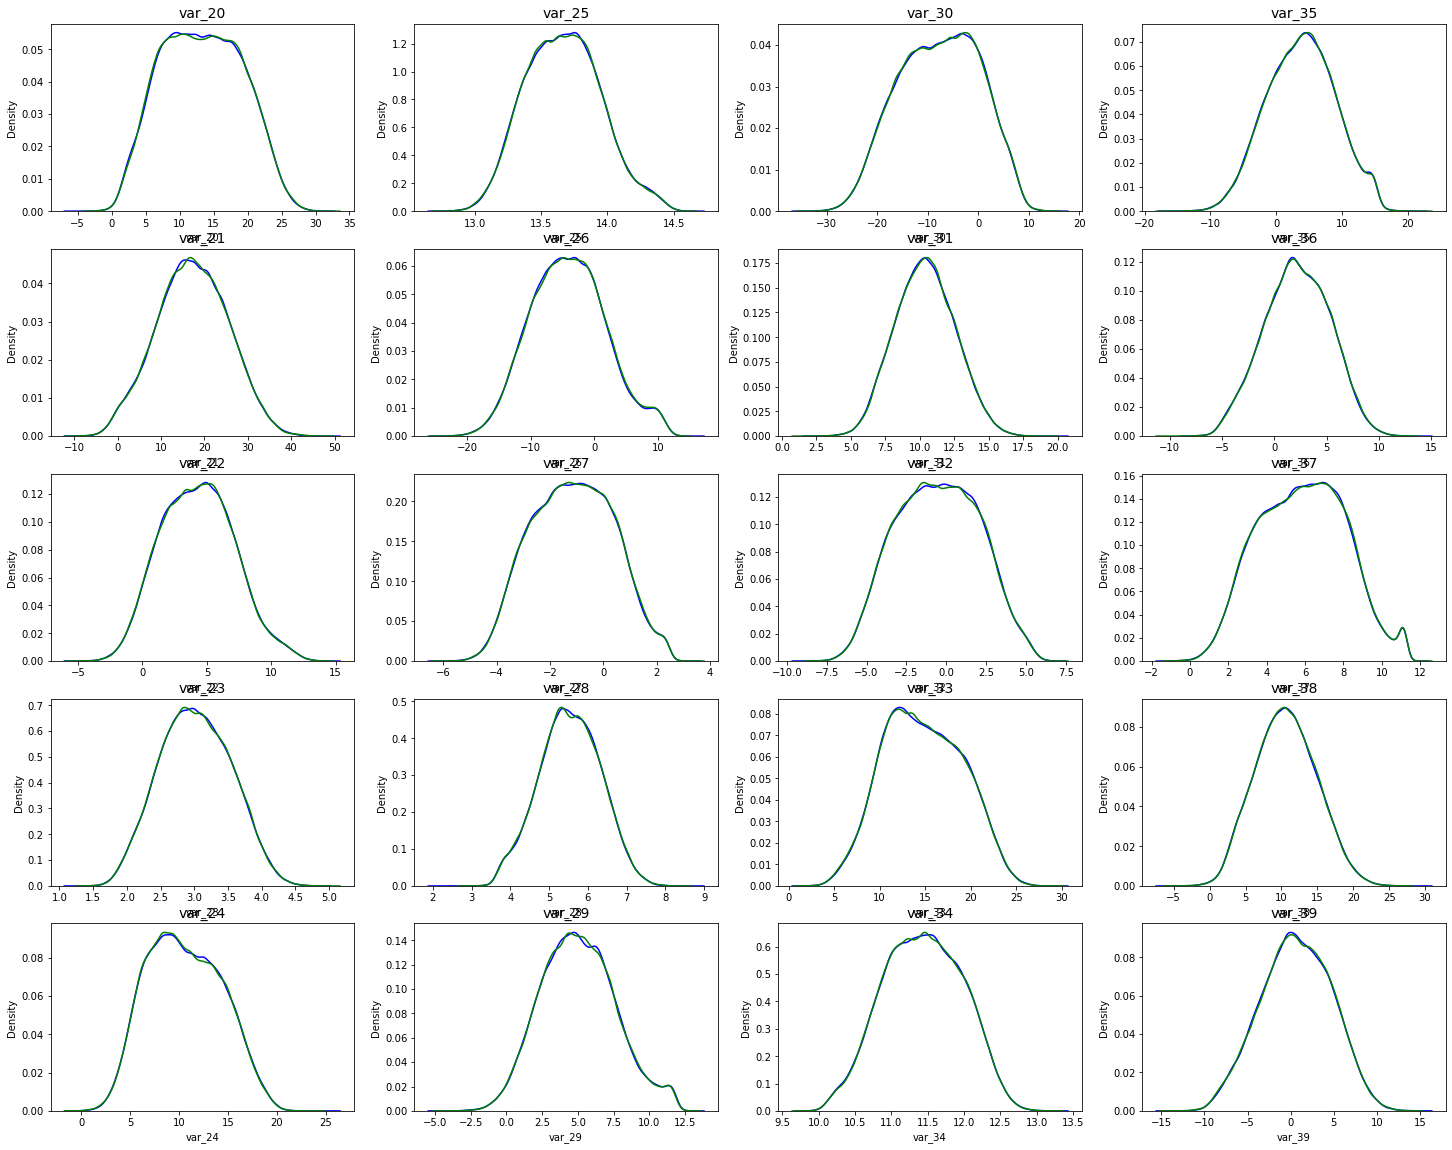

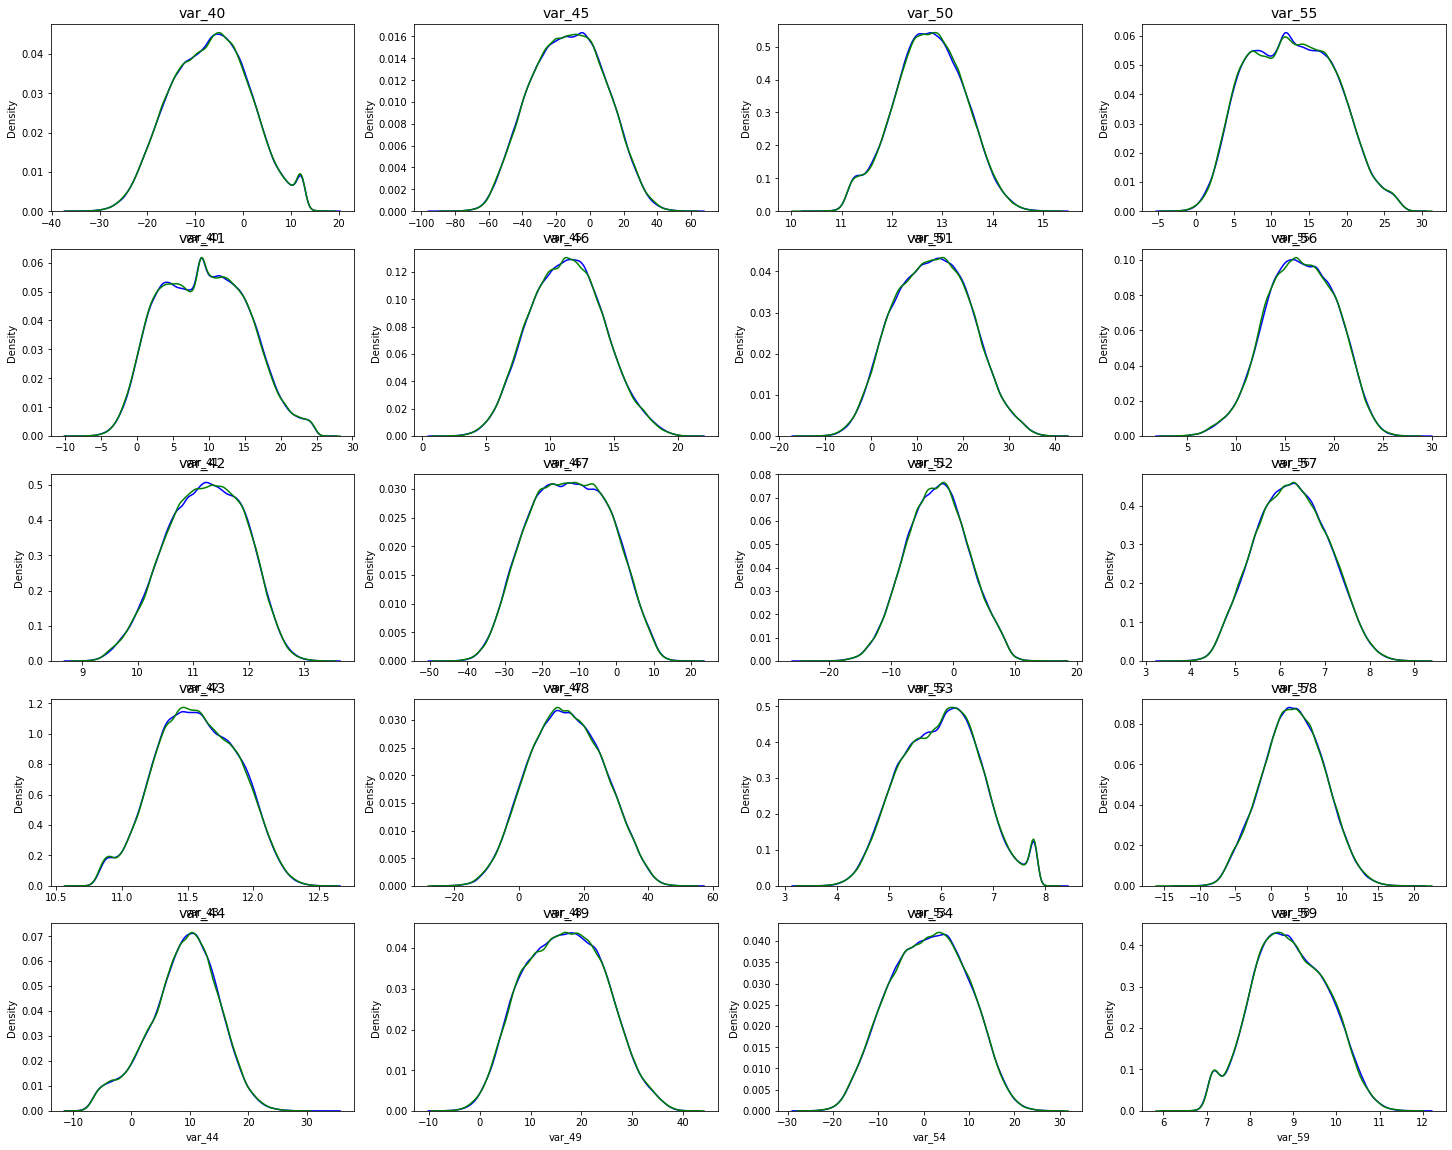

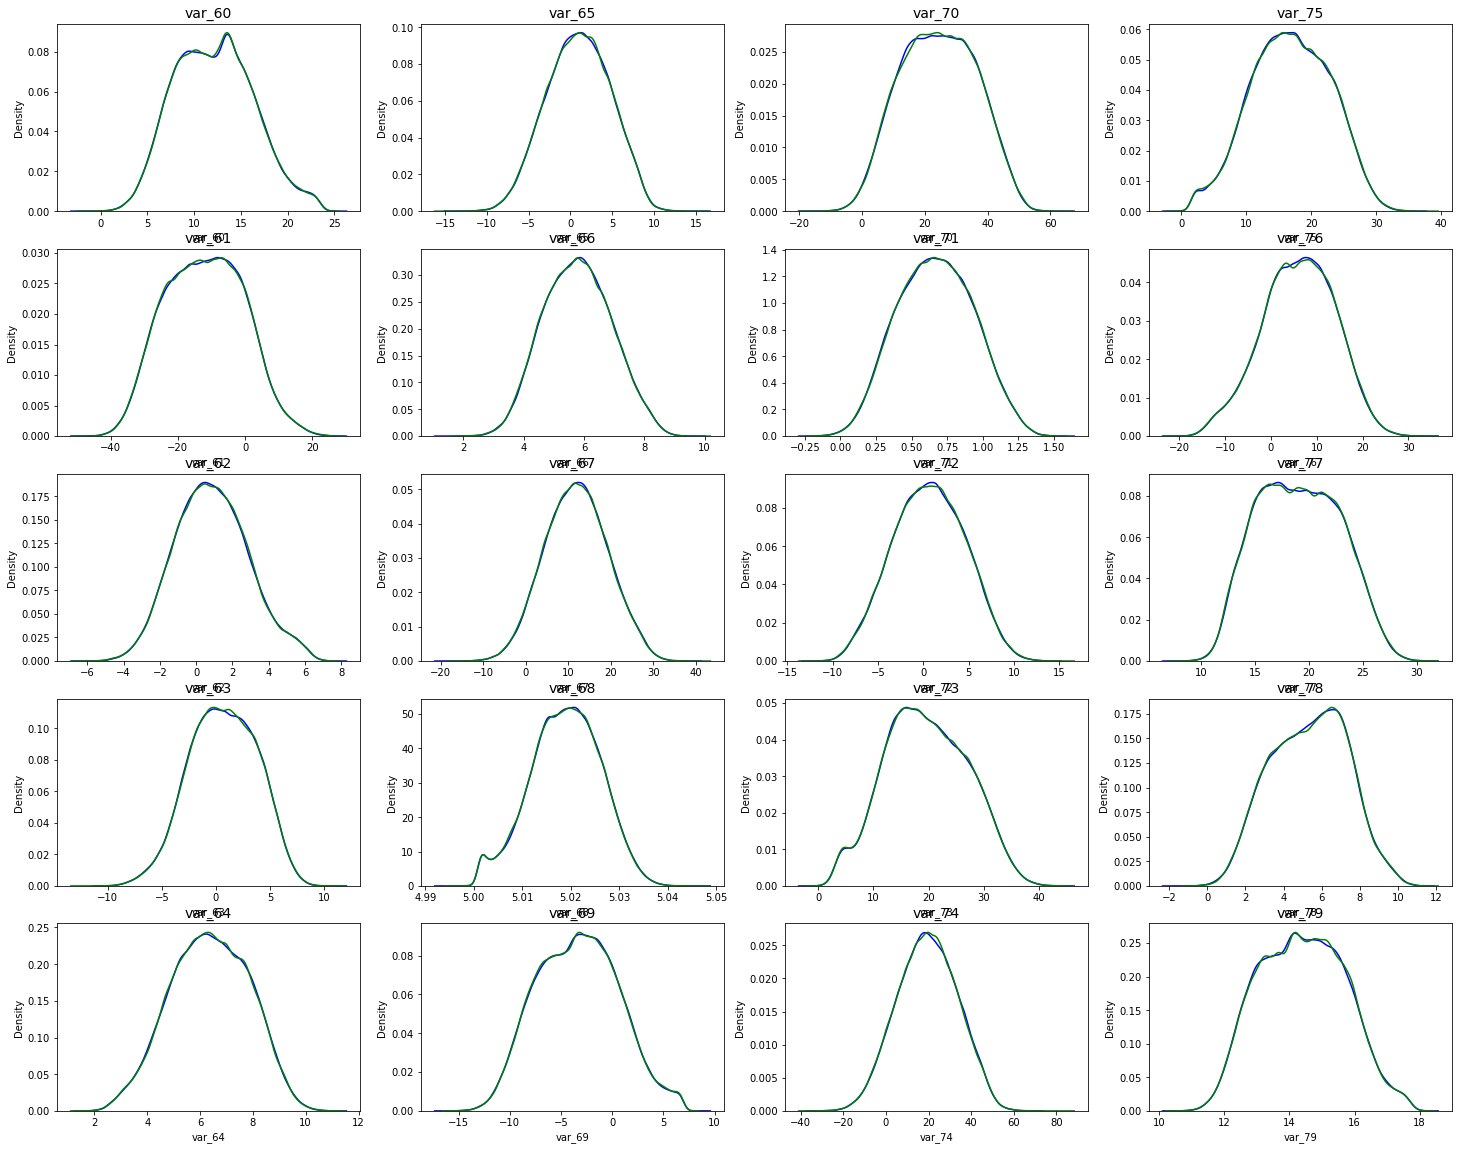

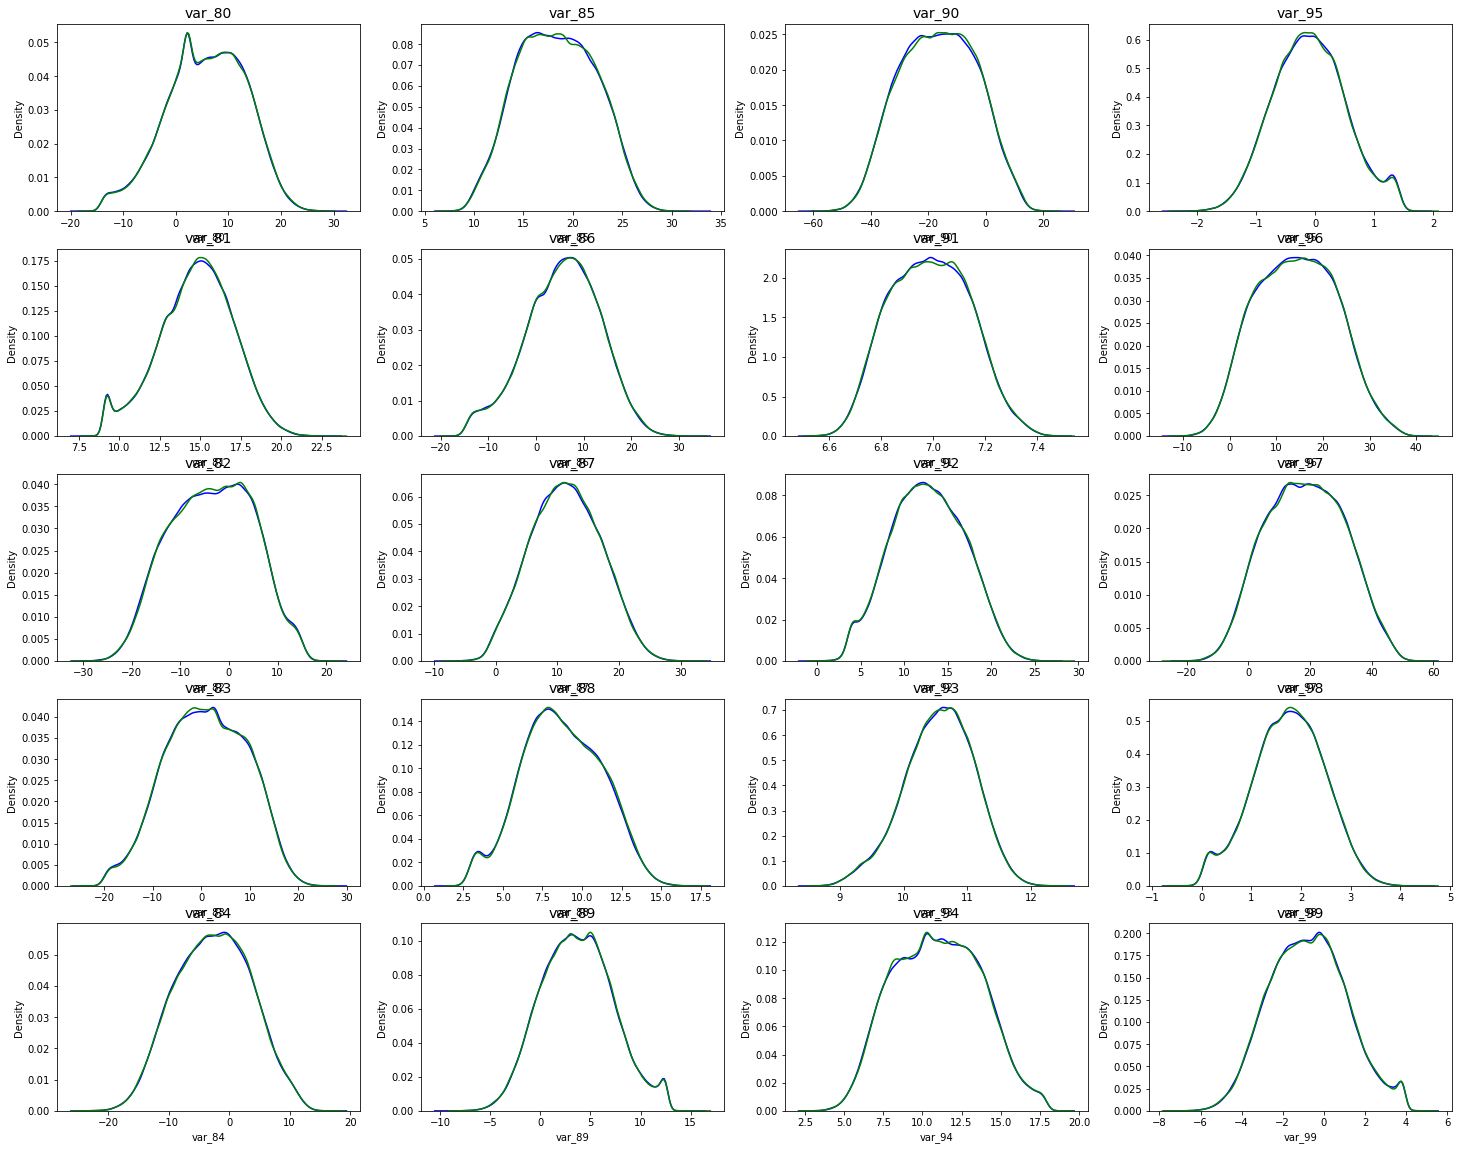

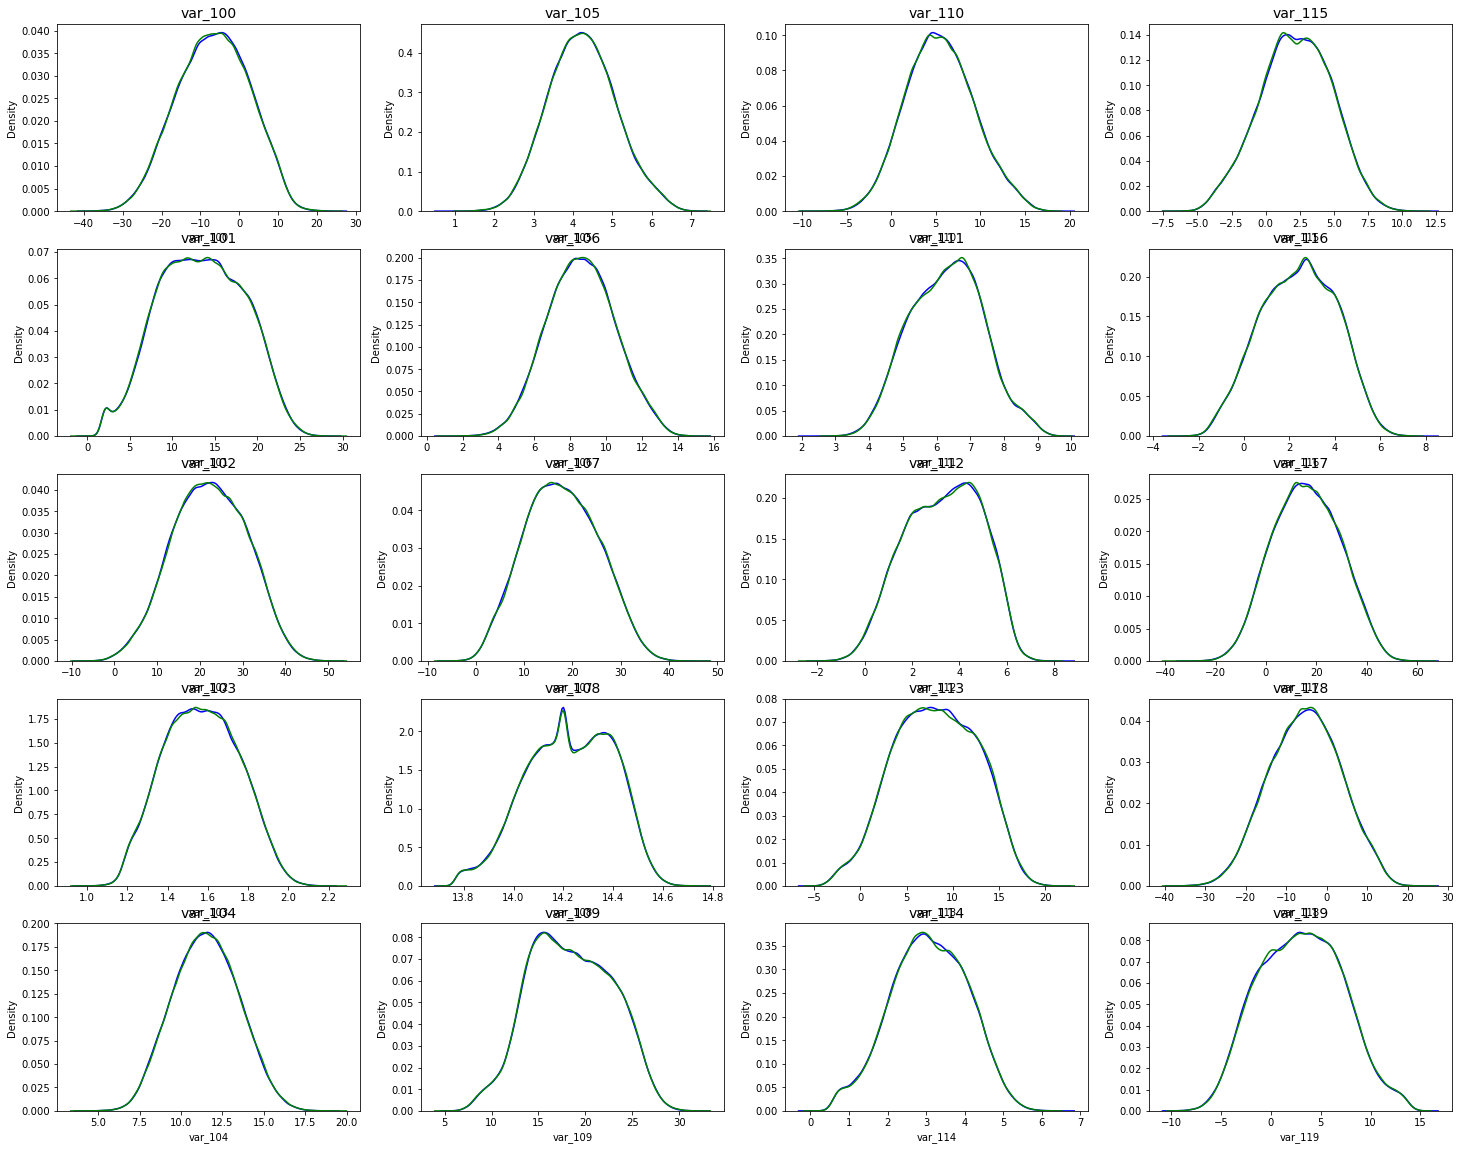

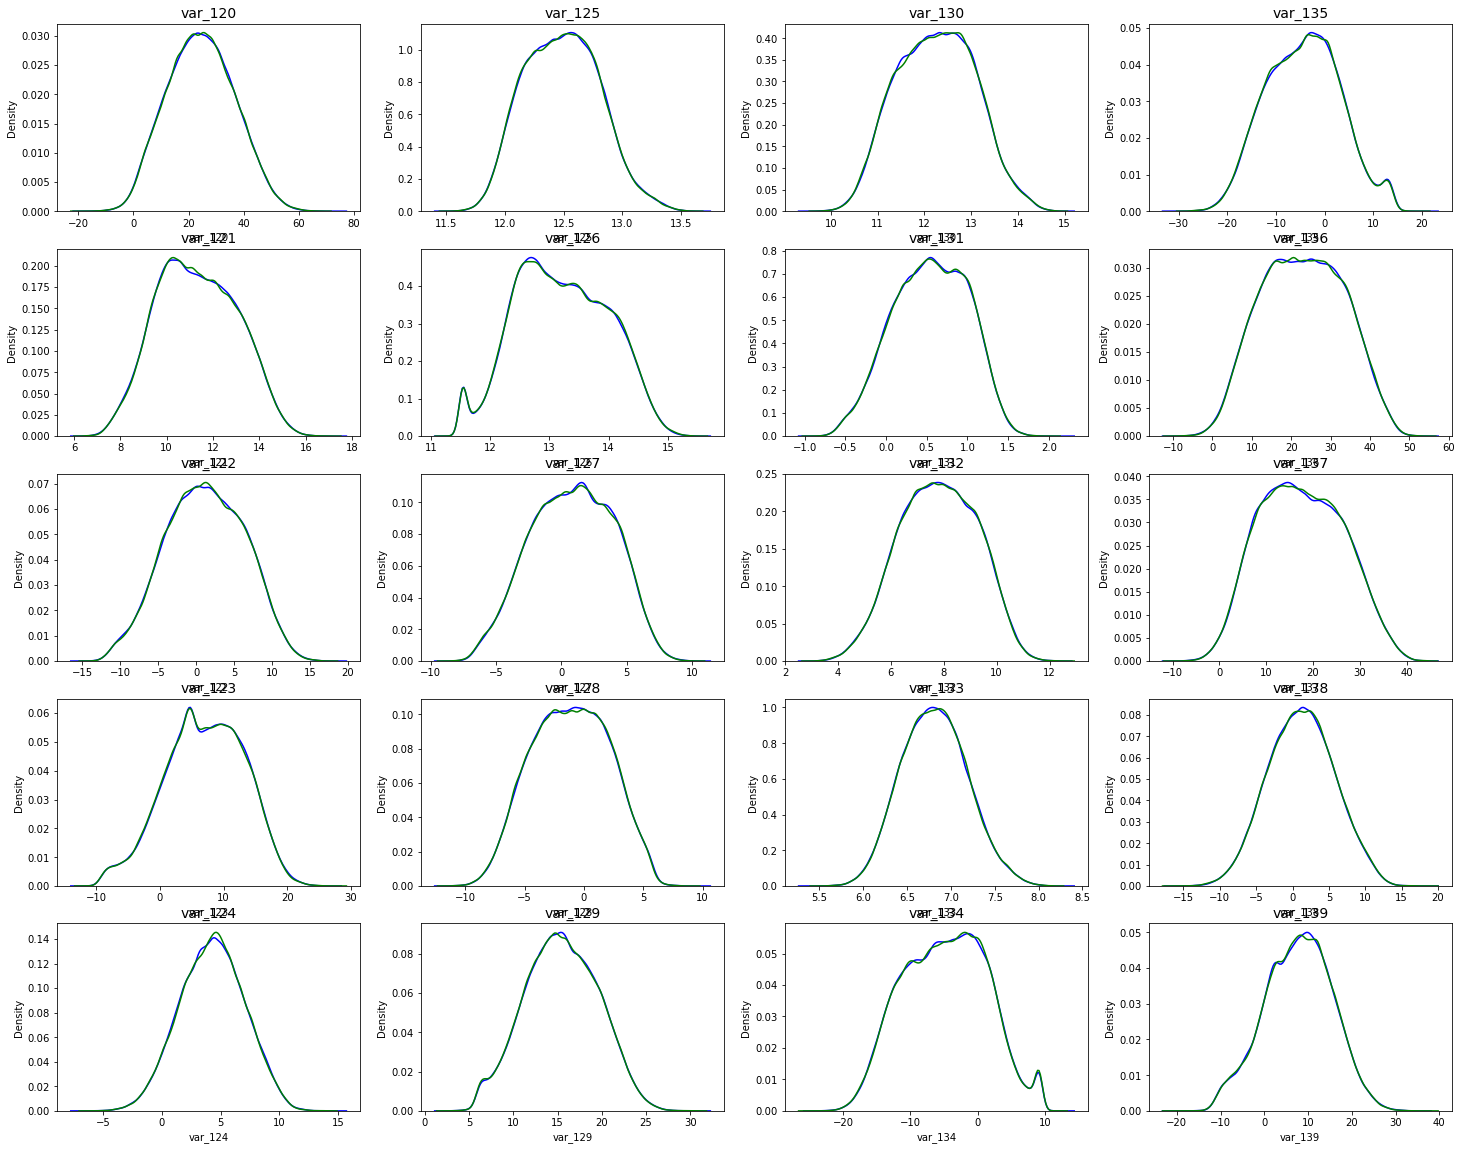

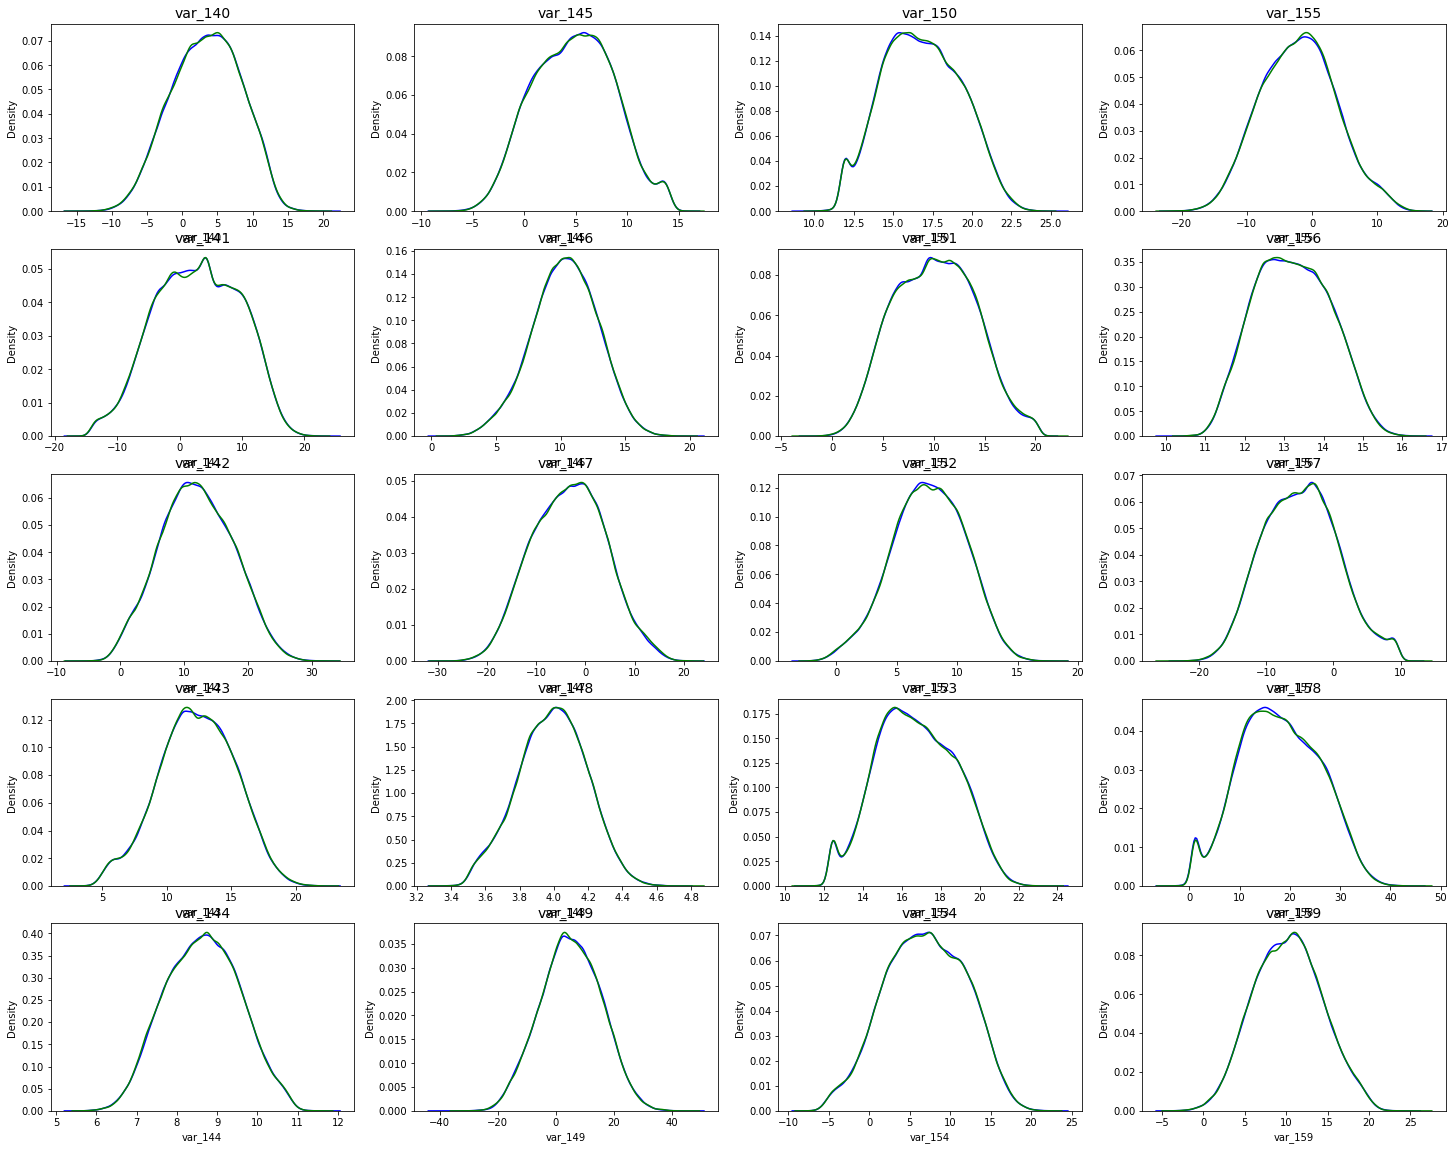

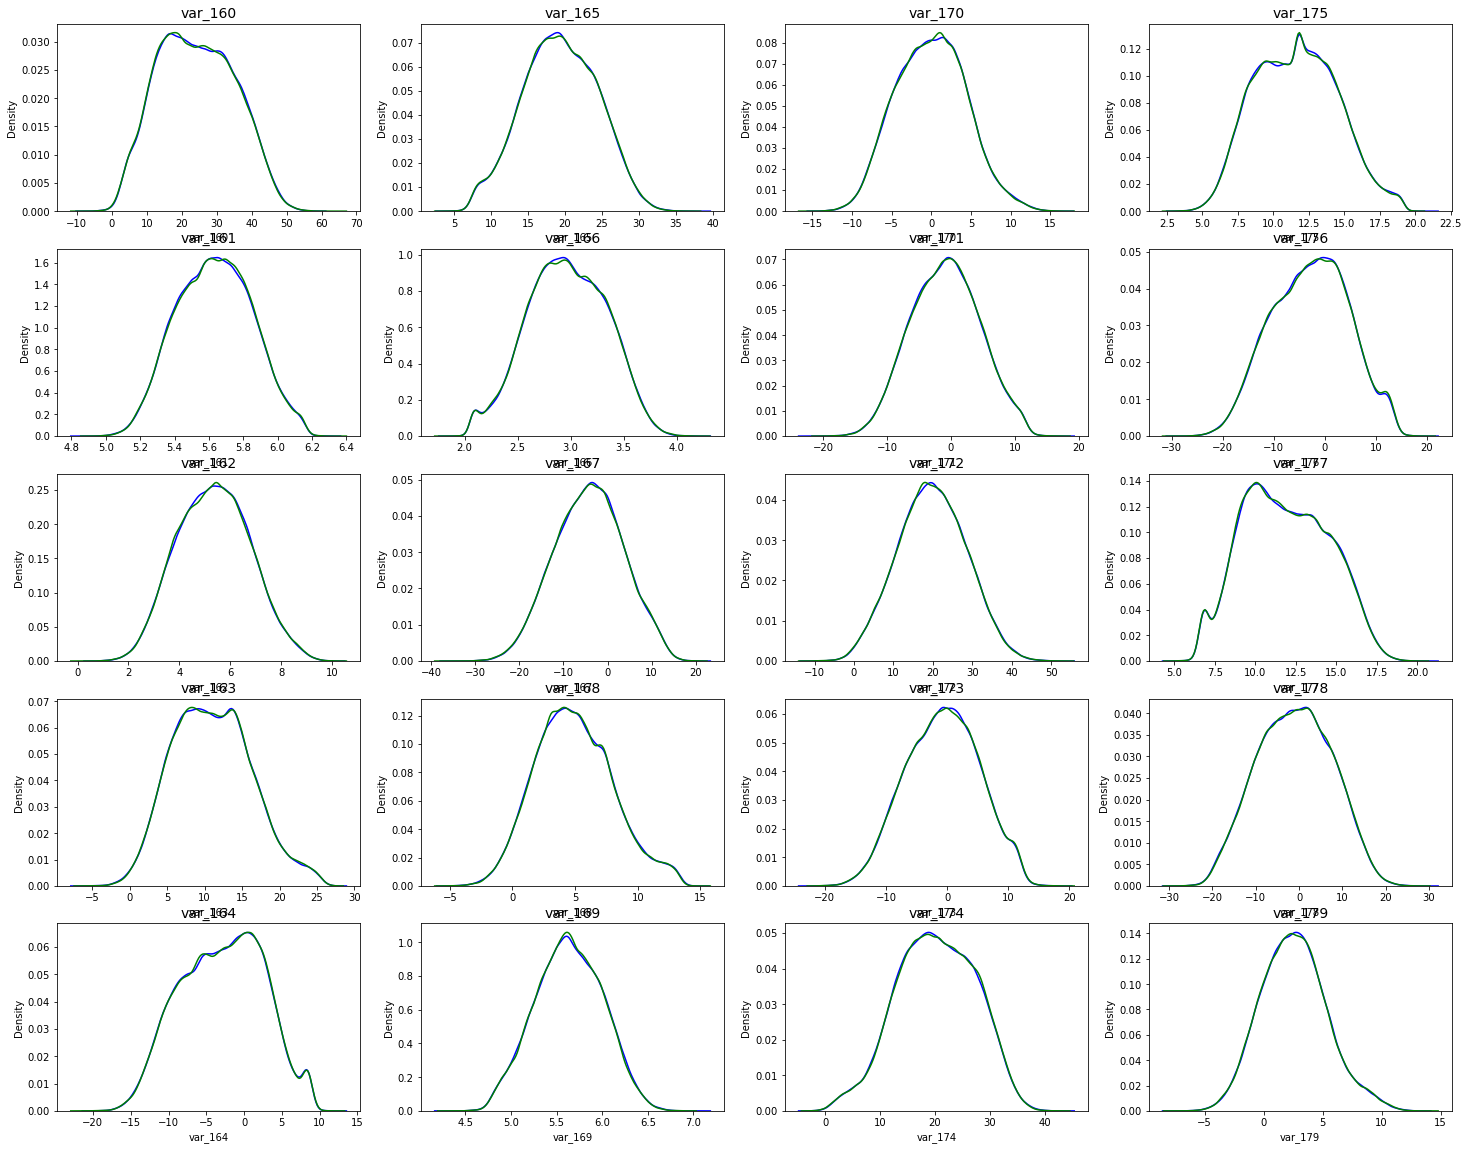

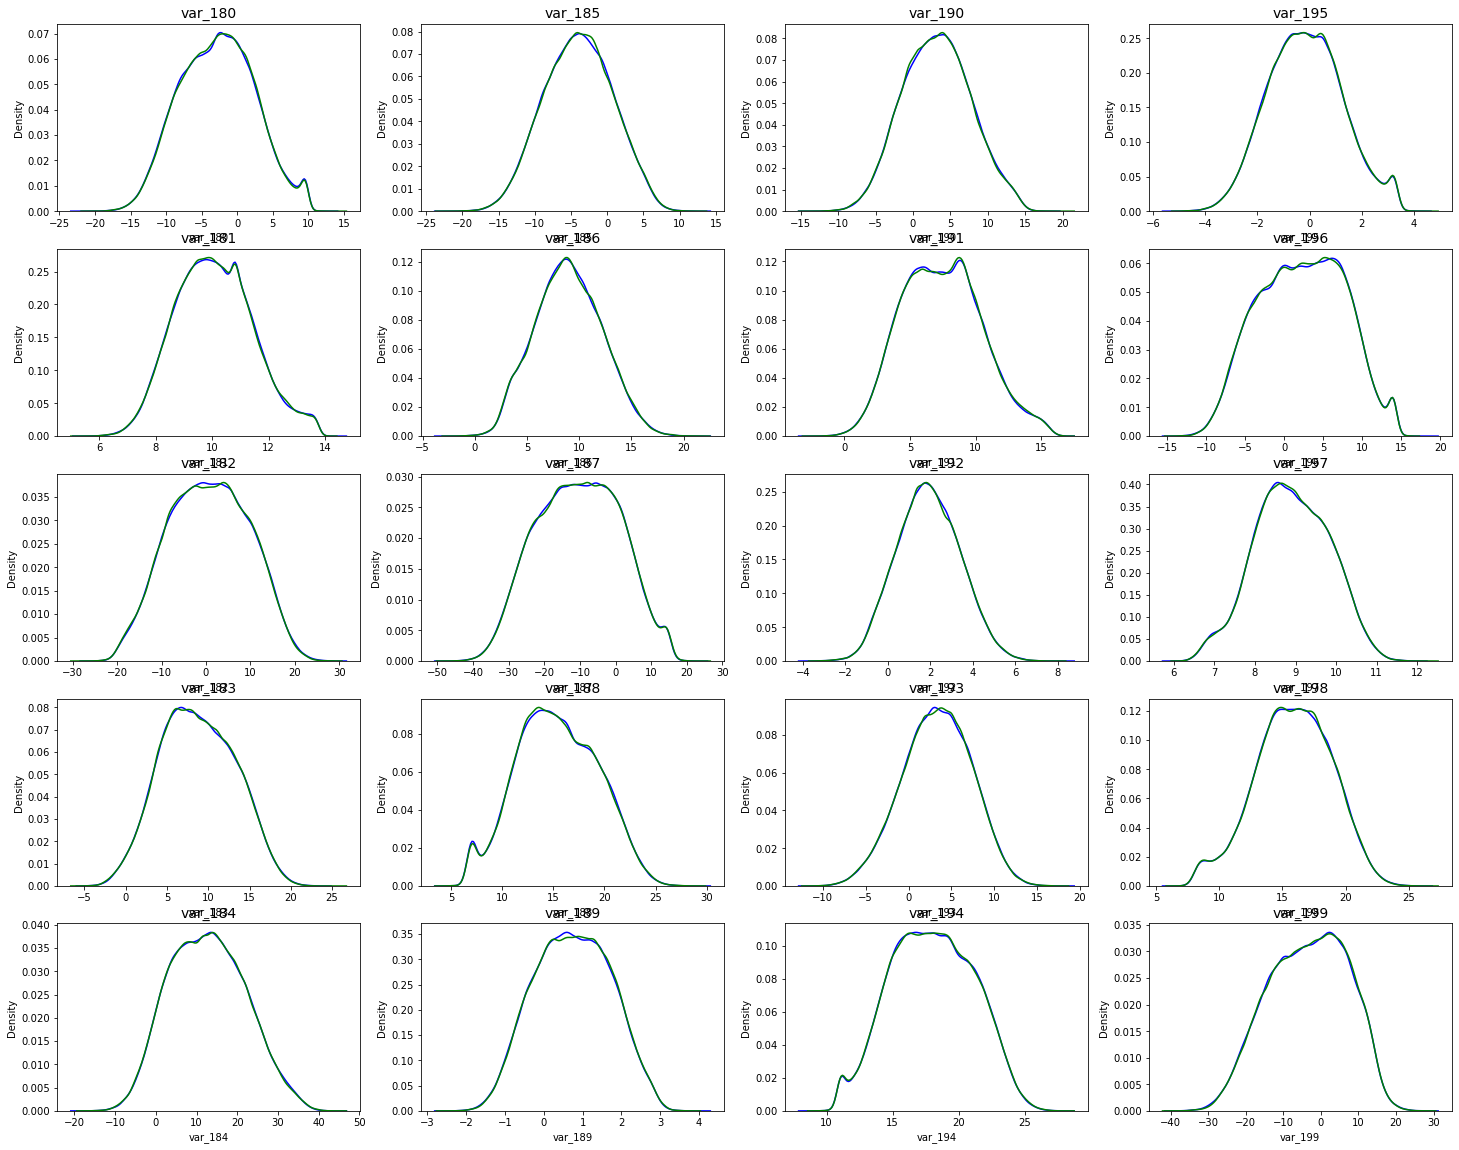

In [20]:
g = group(continuous_feature, 20)

for i in g:
    fig, axes = plt.subplots(5, 4, figsize=(25, 20))

    for num, feature in enumerate(list(i)):
        try:
            train_data, test_data = train[feature].copy(), test[feature].copy()
            sns.kdeplot(train_data, ax=axes[num%5, num//5], color="blue", label="train")
            sns.kdeplot(test_data, ax=axes[num%5, num//5], color="green", label="test")
        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=axes[num%5, num//5], color="blue", label="train")
        axes[num%5, num//5].set_title(feature, fontsize=14)

Распределение признаков в test и train практически совпадают.

## Задание 4: Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

In [22]:
train.loc[train['target']==0, continuous_feature].describe()

var_0          var_1          var_2          var_3  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean       10.626681      -1.695770      10.665876       6.788979   
std         3.008564       4.024813       2.612961       2.040082   
min         0.408400     -15.043400       2.117100      -0.040200   
25%         8.429500      -4.790775       8.698025       5.247625   
50%        10.478600      -1.682600      10.529000       6.817000   
75%        12.693075       1.287700      12.463900       8.317875   
max        20.315000      10.376800      19.353000      13.188300   

               var_4          var_5          var_6          var_7  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean       11.072412      -5.146736       5.389620      16.549306   
std         1.620103       7.827522       0.857983       3.417700   
min         5.074800     -32.562600       2.347300       5.349700   
25%         9.880600     -11.260950       4.756425      13.950125   
50%        11.104400      -4.917700       5.364400      16.460850   
75%        12.253100       0.844600       5.981300      19.108800   
max        16.671400      17.251600       8.447700      27.691800   

               var_8          var_9  ...        var_190        var_191  \
count  179902.000000  179902.000000  ...  179902.000000  179902.000000   
mean        0.262347       7.584907  ...       3.149130       7.390800   
std         3.331105       1.228839  ...       4.522568       2.997847   
min       -10.505500       3.970500  ...     -14.093300      -2.691700   
25%        -2.342575       6.637500  ...      -0.111850       5.130825   
50%         0.371400       7.645600  ...       3.117250       7.297000   
75%         2.919300       8.598075  ...       6.296375       9.461300   
max        10.151300      11.150600  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean        1.949017       3.355403      18.017716      -0.155601   
std         1.476456       3.982819       3.127715       1.422275   
min        -3.814500     -10.845500       8.694400      -5.261000   
25%         0.915300       0.612400      15.656700      -1.178700   
50%         1.928950       3.417550      17.982400      -0.184200   
75%         2.969800       6.217075      20.417500       0.813000   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  179902.000000  179902.000000  179902.000000  179902.000000  
mean        2.260297       8.919032      15.924058      -3.415273  
std         5.441118       0.917467       2.978539      10.434525  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.987375       8.262100      13.896000     -11.312025  
50%         2.359700       8.897700      15.988500      -2.914000  
75%         6.513425       9.601500      18.095400       4.741400  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 200 columns]

In [23]:
train.loc[train['target']==1, continuous_feature].describe()

var_0         var_1         var_2         var_3         var_4  \
count  20098.000000  20098.000000  20098.000000  20098.000000  20098.000000   
mean      11.156418     -1.017613     11.156633      6.864113     11.131337   
std        3.270293      4.220638      2.841075      2.070898      1.649266   
min        0.452800    -14.037000      2.946200      0.374000      5.876200   
25%        8.695875     -4.203475      8.961125      5.314300      9.911250   
50%       11.001350     -0.992650     11.096700      6.900200     11.156300   
75%       13.343700      2.001375     13.047025      8.384725     12.328450   
max       19.458300      9.029800     18.294100     12.706900     15.692500   

              var_5         var_6         var_7         var_8         var_9  \
count  20098.000000  20098.000000  20098.000000  20098.000000  20098.000000   
mean      -4.336522      5.581966     16.514917      0.479432      7.409064   
std        8.140281      0.922442      3.421365      3.340028      1.278709   
min      -28.246100      2.496000      7.302400     -9.839100      4.186100   
25%      -10.615800      4.882250     13.880125     -2.107425      6.451575   
50%       -4.101950      5.601800     16.412700      0.579600      7.484950   
75%        1.619950      6.218550     19.044250      3.127825      8.437200   
max       16.423600      8.285200     27.039800      9.033000     10.588100   

       ...       var_190       var_191       var_192       var_193  \
count  ...  20098.000000  20098.000000  20098.000000  20098.000000   
mean   ...      3.998064      7.864560      1.738266      3.120260   
std    ...      4.814830      3.210779      1.482537      4.067550   
min    ...    -11.906900     -2.343000     -3.317700    -11.783400   
25%    ...      0.466025      5.418550      0.669775      0.343000   
50%    ...      4.017500      7.846550      1.667500      3.176700   
75%    ...      7.407925     10.018400      2.749050      6.063825   
max    ...     16.746100     16.520500      7.647600     17.150400   

            var_194       var_195       var_196       var_197       var_198  \
count  20098.000000  20098.000000  20098.000000  20098.000000  20098.000000   
mean      17.779568     -0.021130      2.688583      8.810815     15.393283   
std        3.193153      1.485975      5.556892      0.952554      3.248123   
min       10.120700     -5.018500    -14.020400      6.119000      6.558700   
25%       15.420025     -1.103950     -1.572225      8.155250     13.232500   
50%       17.730500     -0.057350      2.831050      8.795400     15.427950   
75%       20.201800      0.986450      6.956250      9.517000     17.776425   
max       27.295300      4.088100     17.161400     11.706900     25.857100   

            var_199  
count  20098.000000  
mean      -2.532243  
std       10.435910  
min      -38.852800  
25%      -10.285050  
50%       -1.971850  
75%        5.701475  
max       24.564600  

[8 rows x 200 columns]

In [29]:
test[continuous_feature].describe()

var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.658737      -1.624244      10.707452       6.788214   
std         3.036716       4.040509       2.633888       2.052724   
min         0.188700     -15.043400       2.355200      -0.022400   
25%         8.442975      -4.700125       8.735600       5.230500   
50%        10.513800      -1.590500      10.560700       6.822350   
75%        12.739600       1.343400      12.495025       8.327600   
max        22.323400       9.385100      18.714100      13.142000   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       11.076399      -5.050558       5.415164      16.529143   
std         1.616456       7.869293       0.864686       3.424482   
min         5.484400     -27.767000       2.216400       5.713700   
25%         9.891075     -11.201400       4.772600      13.933900   
50%        11.099750      -4.834100       5.391600      16.422700   
75%        12.253400       0.942575       6.005800      19.094550   
max        16.037100      17.253700       8.302500      28.292800   

               var_8          var_9  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean        0.277135       7.569407  ...       3.189766       7.458269   
std         3.333375       1.231865  ...       4.551239       3.025189   
min        -9.956000       4.243300  ...     -14.093300      -2.407000   
25%        -2.303900       6.623800  ...      -0.095000       5.166500   
50%         0.372000       7.632000  ...       3.162400       7.379000   
75%         2.930025       8.584825  ...       6.336475       9.531100   
max         9.665500      11.003600  ...      20.359000      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.925944       3.322016      17.996967      -0.133657   
std         1.479966       3.995599       3.140652       1.429678   
min        -3.340900     -11.413100       9.382800      -4.911900   
25%         0.882975       0.587600      15.634775      -1.160700   
50%         1.892600       3.428500      17.977600      -0.162000   
75%         2.956000       6.174200      20.391725       0.837900   
max         8.005000      17.632600      27.947800       4.545400   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.290899       8.912428      15.869184      -3.246342  
std         5.446346       0.920904       3.008717      10.398589  
min       -13.944200       6.169600       6.584000     -39.457800  
25%        -1.948600       8.260075      13.847275     -11.124000  
50%         2.403600       8.892800      15.943400      -2.725950  
75%         6.519800       9.595900      18.045200       4.935400  
max        15.920700      12.275800      26.538400      27.907400  

[8 rows x 200 columns]

- среднее по таргету равному 1 у некоторых признаков выше, чем у признаков с таргетом 0 
- среднее и стандартное отклонение на трейне и тесте почти одинаково
- среднее и стандартное отклонение на трейне по таргету 0 больше похоже на среднее и стандартное отклонение на тесте

## Задание 5: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [32]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

C:\Users\raben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\raben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

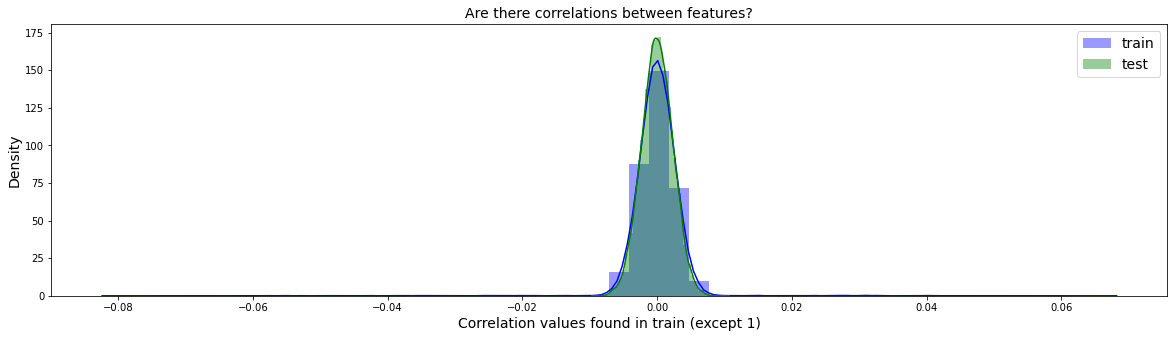

In [33]:
train_correlations = numerical_features.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("target")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

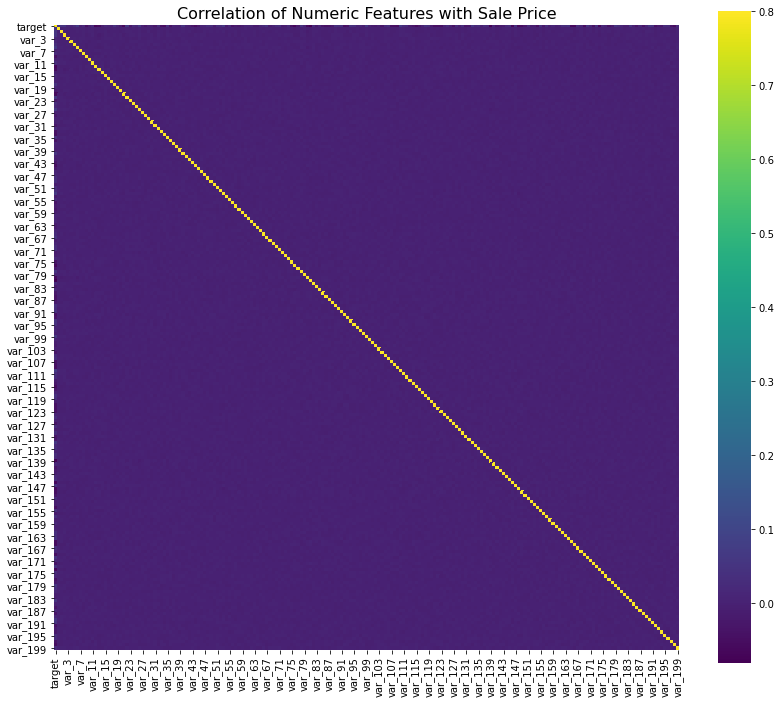

In [34]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

Корреляции между признаками нет. Коэфициент корреляции везде ниже 0.2

## Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [35]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features.fillna(-9999).drop("target", axis=1), target)

Wall time: 5min 33s


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

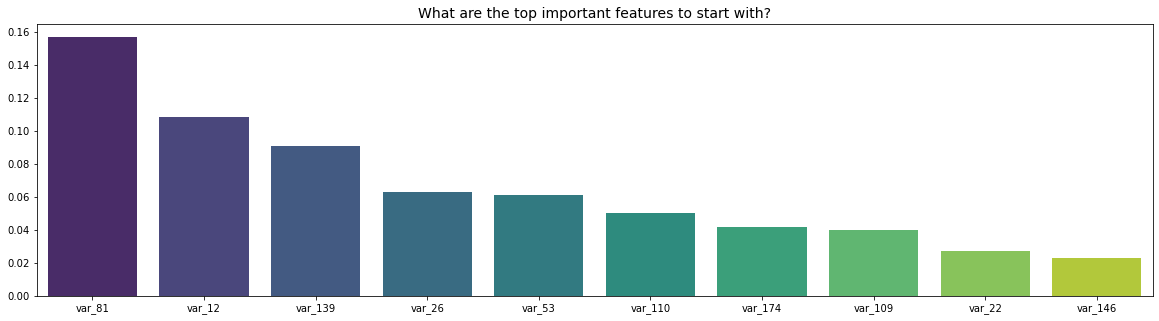

In [36]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

## Задание 7 (опция): Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

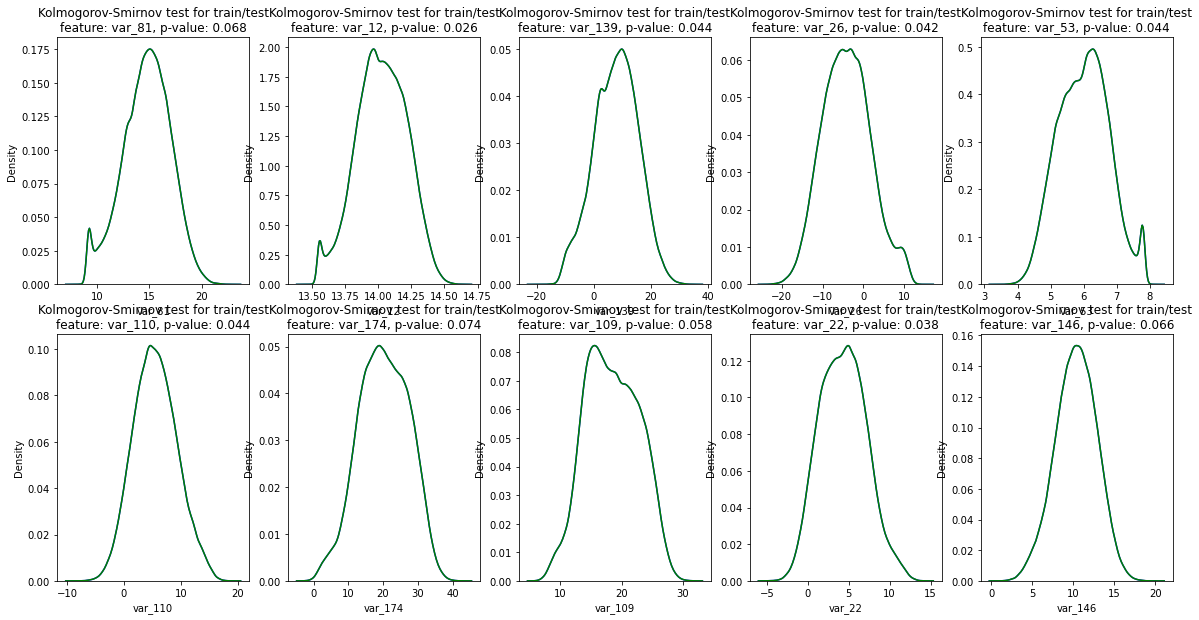

In [37]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(feature_names[idx]):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

In [39]:
features_to_score = numerical_features.drop(["target"], axis=1).columns.tolist()

In [40]:
X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [42]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)
print(f"CV-score: {round(np.mean(cv), 4)}")

C:\Users\raben\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:18:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\raben\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\raben\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-score: 0.5116
Wall time: 12min 14s
Parser   : 337 ms


C:\Users\raben\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:30:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

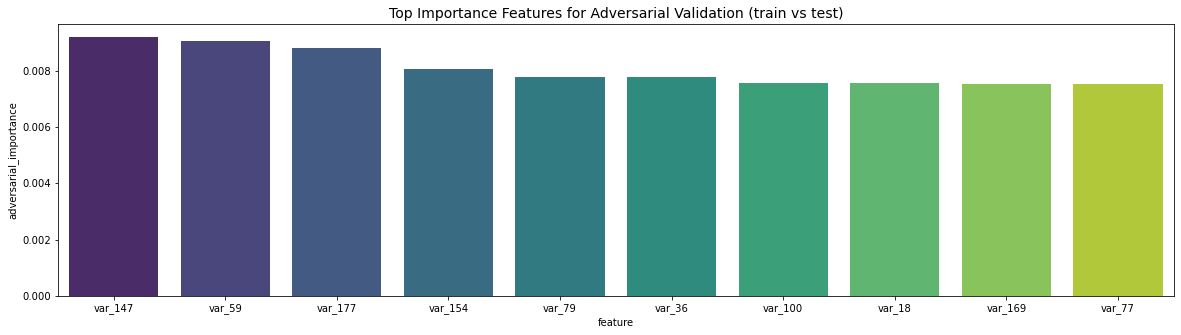

In [43]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

Roc_auc примерно равен 0.5, седовательно, верна гипотеза о том, что обучая модель на некоторых данных она будет работать на таких же данных.